In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
from scipy.interpolate import RegularGridInterpolator
import warnings

In [2]:
# to modify based on the data directory
root_directory = os.getcwd().removesuffix('notebooks')
data_path = r'D:/Data/d18o_so/'
fig_path = root_directory + 'figures/evaluation/'

In [3]:
import sys
sys.path.append(root_directory + 'scripts/') # go to parent dir
import usefull_functions as uf

%load_ext autoreload
%autoreload 2

In [4]:
import custom_density_scale

In [5]:
if not os.path.exists(fig_path): os.mkdir(fig_path)

# Compare the different d18o reconstructions

## Open the d18o products

In [6]:
nemo_d18o = xr.open_dataset(data_path + 'nemo_reconstructed_d18o.nc')
l_lon_nemo, l_lat_nemo, l_depth = nemo_d18o['lon'].values, nemo_d18o['lat'].values, nemo_d18o['depth'].values
interpolator_d18o_rcst_nemo = RegularGridInterpolator((l_depth, l_lat_nemo, l_lon_nemo), nemo_d18o['d18o_recons'].values, bounds_error = False)

In [7]:
ocim_d18o = xr.open_dataset(data_path + 'ocim_reconstructed_d18o.nc')
l_lon_ocim, l_lat_ocim, l_depth_ocim = ocim_d18o['xt'].values, ocim_d18o['yt'].values, ocim_d18o['zt'].values
interpolator_d18o_rcst_ocim = RegularGridInterpolator((l_depth_ocim, l_lat_ocim, l_lon_ocim), ocim_d18o['d18o_recons'].values, bounds_error = False)

In [8]:
dsClim = xr.open_dataset(data_path + 'WOCE_climatology_Lg&S_d18o.nc')
l_depth0 = uf.create_l_depth()
interpolator_d18o_GISS = RegularGridInterpolator((l_depth0, l_lat_nemo, l_lon_nemo), dsClim['seawater_d18O'].values, bounds_error = False)

In [9]:
TMI_d18o = xr.open_dataset(data_path + 'tmi_reconstructed_d18o.nc')
l_lon_tmi, l_lat_tmi, l_depth_tmi = TMI_d18o['xt'].values, TMI_d18o['yt'].values, TMI_d18o['zt'].values
interpolator_d18o_rcst_tmi = RegularGridInterpolator((l_depth_tmi, l_lat_tmi, l_lon_tmi), TMI_d18o['d18o_recons'].values, bounds_error = False)

## Measure the global error to reconstruct the GISS compilation

The idea of our reconstruction is that it should correctly represent the deep $\delta^{18}O$ structure. Thus, it is interesting to compare it to the existing Legrande & Schmidt climatology, to see if there is a depth below which the products we define fare better than the original product. 
In order to investigate this we design a measurement of the error which computes for a set of depth levels the RMSE of the error associated between the different reconstructions and the data in the GISS compilation, below the associated depth. It is defined as follows:

$f(d) = \sqrt{\sum_{d_i \geq d} (\delta^{18}O_{sw}(d_i) - \delta^{18}O_{p}(d_i))^2}$

In [10]:
d18o_GISS_db = pd.read_table(data_path + 'giss_d18o.txt')
d18o_GISS_db['Longitude'] = [lon if lon >= 0 else 360 + lon for lon in d18o_GISS_db['Longitude']]

In [11]:
d18o_GISS_db['d18O_rcst_nemo'] = interpolator_d18o_rcst_nemo((d18o_GISS_db['Depth'], d18o_GISS_db['Latitude'], d18o_GISS_db['Longitude']))
d18o_GISS_db['d18O_rcst_ocim'] = interpolator_d18o_rcst_ocim((d18o_GISS_db['Depth'], d18o_GISS_db['Latitude'], d18o_GISS_db['Longitude']))
d18o_GISS_db['d18O_rcst_tmi'] = interpolator_d18o_rcst_tmi((d18o_GISS_db['Depth'], d18o_GISS_db['Latitude'], d18o_GISS_db['Longitude']))
d18o_GISS_db['d18O_GISS'] = interpolator_d18o_GISS((d18o_GISS_db['Depth'], d18o_GISS_db['Latitude'], d18o_GISS_db['Longitude']))

In [12]:
d18o_GISS_db = d18o_GISS_db.where((d18o_GISS_db['d18O'] != '**')).dropna()
d18o_GISS_db['d18O'] = d18o_GISS_db['d18O'].astype(float)

Here we can change the region we look at based on the interest we have

In [13]:
mask_all = (d18o_GISS_db['Latitude'] <= 100)
mask_Atl = (d18o_GISS_db['Latitude'] >= -40) & ((d18o_GISS_db['Longitude'] >= 295) | (d18o_GISS_db['Longitude'] <= 30))
mask_SO = (d18o_GISS_db['Latitude'] <= -40)
mask_Ind = (d18o_GISS_db['Latitude'] >= -40) & (d18o_GISS_db['Latitude'] <= 20) & ((d18o_GISS_db['Longitude'] >= 30) & (d18o_GISS_db['Longitude'] <= 120))
mask_Pac = (d18o_GISS_db['Latitude'] >= -40) & (d18o_GISS_db['Latitude'] <= 70) & ((d18o_GISS_db['Longitude'] >= 120) & (d18o_GISS_db['Longitude'] <= 295))

In [14]:
# here we define the different depth levels for which we will compute the error
new_l_depth = list(l_depth_ocim[0:25]).copy()
for i in range(50):
    new_l_depth.append(1000 + i * 100)

In [15]:
l_fields = ['d18O_rcst_nemo', 'd18O_rcst_ocim', 'd18O_rcst_tmi', 'd18O_GISS']; n = len(l_fields)

# to change based on what we want to show
l_masks = [mask_all, mask_SO, mask_Atl]; l_labels = ['Global', 'Southern Ocean', 'Atlantic Ocean']; l_labels2 = ['Global', 'Atl Oc', 'w/o SO']
# l_masks = [mask_all, mask_Ind, mask_Pac]; l_labels = ['Global', 'Indian Ocean', 'Pacific Ocean']; l_labels2 = ['Global', 'Ind Oc', 'Pac Oc']


label_fig = ''
for i in range(len(l_labels)): label_fig += l_labels[i] + '_'

rmse_basins = np.empty((len(l_masks), len(new_l_depth), n))
nb_points = np.empty((len(l_masks), len(new_l_depth)))


for i_mask in range(len(l_masks)):
    aux = d18o_GISS_db.where(l_masks[i_mask]).dropna()
    
    for idepth in range(len(new_l_depth) - 1):
        aux_depth = aux.where(aux['Depth'] >= new_l_depth[idepth]).dropna()
        nb_points[i_mask, idepth] = len(aux_depth.index)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            for ifield in range(n):
                rmse_basins[i_mask, idepth, ifield] = np.sqrt(np.nanmean((aux_depth['d18O'] - aux_depth[l_fields[ifield]])**2))

In [18]:
# Difference in the d18o recons on the global ocean  below 1500m: TMI vs OCIM
print(new_l_depth[30], np.nanmean(rmse_basins[0, 30:70, 2] - rmse_basins[0, 30:70, 1]))

1500 0.00996774968402242


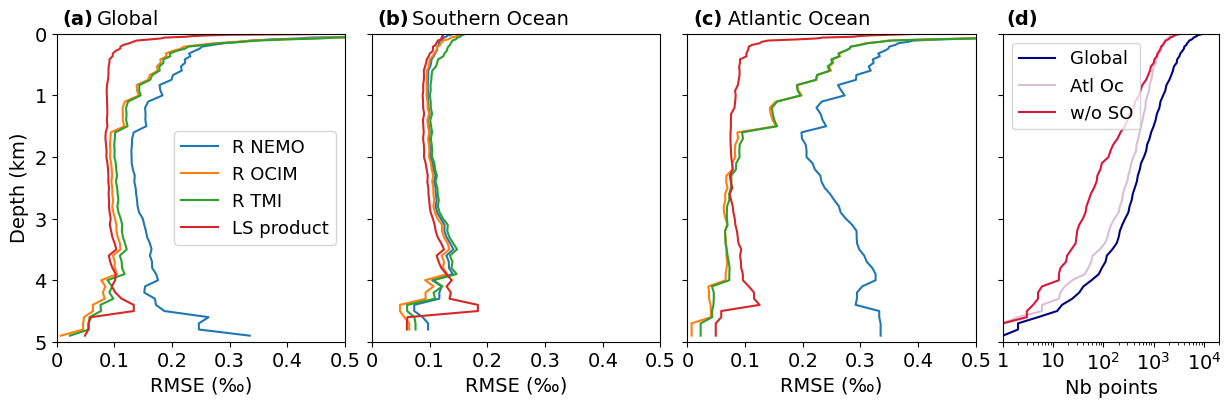

In [19]:
fig = plt.figure(figsize = (15, 4)); gs = fig.add_gridspec(1, 4, wspace = 0.1, width_ratios = [1, 1, 1, 0.75]); font = 14
labels = ['R NEMO', 'R OCIM', 'R TMI', 'LS product'] #'OCIM-LS', 


for i_plot in range(3):
    ax = fig.add_subplot(gs[0, i_plot])
    for ifield in range(n):
        ax.plot(rmse_basins[i_plot, :, ifield], new_l_depth, label = labels[ifield])
    ax.set_ylim(5000, 0); ax.set_xlim(0, 0.5)
    ax.set_xlabel('RMSE (‰)', fontsize = font); ax.set_xticks([0.1 * i for i in range(6)]); ax.set_xticklabels([0, '0.1', '0.2', '0.3', '0.4', '0.5'], fontsize = font)
    ax.set_yticks([1000 * i for i in range(6)]); ax.set_yticklabels([], fontsize = font)
    ax.text(0.01, -150, uf.panels_letter_parenthesis[i_plot], fontsize = font, fontweight = 'bold'); ax.text(0.07, -150, l_labels[i_plot], fontsize = font)
    if i_plot == 0: plt.legend(fontsize = font - 1); ax.set_ylabel('Depth (km)', fontsize = font); ax.set_yticklabels([i for i in range(6)], fontsize = font)

ax = fig.add_subplot(gs[0, 3])
colors = ['navy', 'thistle', 'crimson']
for i_mask in range(3):
    ax.plot(nb_points[i_mask, :], new_l_depth, label = l_labels2[i_mask], c= colors[i_mask])
ax.set_ylim(5000, 0)
ax.set_xlabel('Nb points', fontsize = font); ax.set_xscale('log'); ax.set_xlim(1, 20000) ; ax.set_xticks([10**i for i in range(5)]); ax.set_xticklabels(['1', '10', '$10^2$', '$10^3$', '$10^4$'], fontsize = font)
ax.set_yticks([1000 * i for i in range(6)]); ax.set_yticklabels([])
ax.text(1.2, -150, '(d)', fontsize = font, fontweight = 'bold')#; ax.text(0.07, -150, 'Atlantic Ocean', fontsize = font)
plt.legend(fontsize = font - 1)

# plt.savefig(fig_path + 'RMSE_4products_vs_GISS_' + label_fig.replace(' ', '_') + '.png', bbox_inches = 'tight')

In [20]:
error_Pac_inv = np.empty((len(new_l_depth), 3))
aux = d18o_GISS_db.where(mask_Pac).dropna()

for idepth in range(len(new_l_depth) - 1):
    aux_depth = aux.where(aux['Depth'] >= new_l_depth[idepth]).dropna()
    nb_points[i_mask, idepth] = len(aux_depth.index)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        # fields: 'd18O_rcst_ocim', 'd18O_rcst_tmi'
        for ifield in range(1, 4):
            error_Pac_inv[idepth, ifield - 1] = np.nanmean(aux_depth['d18O'] - aux_depth[l_fields[ifield]])

In [21]:
print('Depths : ', new_l_depth[35:64])
print('Error OCIM: ', error_Pac_inv[35:64, 0])
print('Error TMI: ', error_Pac_inv[35:64, 1])
print('Error LS: ', error_Pac_inv[35:64, 2])

Depths :  [2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800]
Error OCIM:  [0.07344136 0.0810347  0.08003241 0.07890779 0.07565087 0.07565087
 0.07501007 0.07279827 0.08475651 0.08964226 0.09907321 0.09951695
 0.1045772  0.10300829 0.10595807 0.10590736 0.10527443 0.10527443
 0.10873789 0.10604482 0.10953954 0.10953954 0.10953954 0.10500903
 0.10975235 0.12058716        nan        nan        nan]
Error TMI:  [0.09640287 0.10577277 0.10533267 0.10332114 0.10026937 0.10026937
 0.1013322  0.09824611 0.11194591 0.11841568 0.1294832  0.12797107
 0.13311974 0.12902951 0.13094349 0.12575509 0.12638675 0.12638675
 0.13089666 0.12404778 0.12325991 0.12325991 0.12325991 0.11722118
 0.12409693 0.13475514        nan        nan        nan]
Error LS:  [-0.01544018 -0.00685353 -0.00671903 -0.00575828 -0.00446962 -0.00446962
 -0.00177221  0.00636788  0.01871124  0.02520536  0.0345

In [22]:
l_depth[45:64]

array([ 947.4479, 1045.8542, 1151.9912, 1265.8615, 1387.377 , 1516.3636,
       1652.5685, 1795.6708, 1945.2955, 2101.0266, 2262.4216, 2429.0251,
       2600.3804, 2776.0393, 2955.5703, 3138.565 , 3324.6409, 3513.4456,
       3704.6567], dtype=float32)

## Compare the NA dye around the SO and its impact on d18o

### Scripts to get NA max

In [23]:
TMI_2deg = xr.open_dataset(data_path + 'TMI_2deg_2010_water_mass_fractions.nc')
extratm21 = xr.open_dataset(data_path + 'tm21ah21_extrapolated_dyes_regridded.nc')
ocim_frac = xr.open_dataset(data_path + 'ocim_steady_dyes.nc')

In [24]:
l_lon_nemo3D, l_lat_nemo3D = np.meshgrid(l_lon_nemo, l_lat_nemo)
l_lon_ocim3D, l_lat_ocim3D = np.meshgrid(l_lon_ocim, l_lat_ocim)
l_lon_tmi3D, l_lat_tmi3D = np.meshgrid(l_lon_tmi, l_lat_tmi)

In [25]:
from scipy.interpolate import RegularGridInterpolator
def regrid(values, l_depth_ini, lat_ini, lon_ini, l_depth_fin, l_lat_fin, l_lon_fin):
    l_lon3D_fin, l_lat3D_fin, l_depth3D_fin = np.meshgrid(l_lon_fin, l_lat_fin, l_depth_fin)
    grid_fin = np.column_stack((l_depth3D_fin.flatten(), l_lat3D_fin.flatten(), l_lon3D_fin.flatten()))
    
    interpolator = RegularGridInterpolator((l_depth_ini, lat_ini, lon_ini), values, method='linear', bounds_error=False, fill_value=None)
    return(interpolator(grid_fin).reshape(len(l_lat_fin), len(l_lon_fin), len(l_depth_fin)))

In [26]:
# here we interpolate salinities along the different grids to get the salinity associated to the NA max
S_nemo = regrid(dsClim['absolute_salinity'].values, l_depth0, l_lat_nemo, l_lon_nemo, l_depth, l_lat_nemo, l_lon_nemo).transpose((2, 0, 1))
S_ocim = regrid(dsClim['absolute_salinity'].values, l_depth0, l_lat_nemo, l_lon_nemo, l_depth_ocim, l_lat_ocim, l_lon_ocim).transpose((2, 0, 1))
S_tmi = regrid(dsClim['absolute_salinity'].values, l_depth0, l_lat_nemo, l_lon_nemo, l_depth_tmi, l_lat_tmi, l_lon_tmi).transpose((2, 0, 1))
flatten_S_nemo, flatten_S_ocim, flatten_S_tmi = S_nemo[46:].flatten(), S_ocim[25:].flatten(), S_tmi[18:].flatten()

In [27]:
dye_nemo_max, dye_ocim_max, dye_tmi_max = np.empty((3, 72)), np.empty((3, 72)), np.empty((3, 72))
d18o_na_max = np.empty((3, 72)) # contains the d18o associated to the NA max for the 3 models: nemo, ocim and tmi
salinity_associated = np.empty((3, 72)); max_salinity = []

l_lon, ilon = [], 0
dyes_deep = ['AA', 'NA', 'HS']
new_nav_lat, new_nav_lon = uf.get_new_nav_lat_lon(data_path)

flatten_d18o_nemo, flatten_d18o_ocim, flatten_d18o_tmi = nemo_d18o['d18o_recons'][46:].values.flatten(), ocim_d18o['d18o_recons'][25:].values.flatten(), TMI_d18o['d18o_recons'][18:].values.flatten()
flatten_dyes_nemo, flatten_dyes_ocim, flatten_dyes_tmi = [extratm21['Dye' + dye][46:].values.flatten() for dye in dyes_deep], [ocim_frac['dye' + dye + '_steady'][25:].values.flatten() for dye in dyes_deep], [TMI_2deg['dye' + dye][18:].values.flatten() for dye in dyes_deep]

for lon in range(0, 360, 5):
    mask_nemo = (l_lon_nemo3D >= lon - 2) & (l_lon_nemo3D <= lon + 2) & (l_lat_nemo3D <= -30) & (l_lat_nemo3D >= -60)
    mask_ocim = (l_lon_ocim3D >= lon - 2) & (l_lon_ocim3D <= lon + 2) & (l_lat_ocim3D <= -30) & (l_lat_ocim3D >= -60)
    mask_tmi = (l_lon_tmi3D >= lon - 2) & (l_lon_tmi3D <= lon + 2) & (l_lat_tmi3D <= -30) & (l_lat_tmi3D >= -60)

    index_nemo = np.nanargmax(np.where(mask_nemo, extratm21['DyeNA'].values[46:], np.nan))
    index_ocim = np.nanargmax(np.where(mask_ocim, ocim_frac['dyeNA_steady'].values[25:], np.nan))
    index_tmi = np.nanargmax(np.where(mask_tmi, TMI_2deg['dyeNA'].values[18:], np.nan))
    
    max_salinity.append(np.nanmax(np.where(mask_nemo, dsClim['absolute_salinity'].values[21:], np.nan)))

    d18o_na_max[0, ilon] = flatten_d18o_nemo[index_nemo]; salinity_associated[0, ilon] = flatten_S_nemo[index_nemo]
    d18o_na_max[1, ilon] = flatten_d18o_ocim[index_ocim]; salinity_associated[1, ilon] = flatten_S_ocim[index_ocim]
    d18o_na_max[2, ilon] = flatten_d18o_tmi[index_tmi]; salinity_associated[2, ilon] = flatten_S_tmi[index_tmi]
    
    for i in range(len(dyes_deep)):
        dye_nemo_max[i, ilon] = flatten_dyes_nemo[i][index_nemo]
        dye_ocim_max[i, ilon] = flatten_dyes_ocim[i][index_ocim]
        dye_tmi_max[i, ilon] = flatten_dyes_tmi[i][index_tmi]

    l_lon.append(lon); ilon += 1

In [28]:
# Re-order the arrays with different longitudes so that we see more clearly the NA erosion
n = np.shape(dye_nemo_max)[1]
dye_nemo_max_reshaped, dye_ocim_max_reshaped, dye_tmi_max_reshaped = dye_nemo_max.copy(), dye_ocim_max.copy(), dye_tmi_max.copy(); l_lon_reshaped = l_lon.copy(); 
d18o_na_max_reshaped = d18o_na_max.copy(); salinity_associated_reshaped = salinity_associated.copy(); max_salinity_reshaped = np.array(max_salinity).copy()

dye_nemo_max_reshaped[:, (n-60):] = dye_nemo_max[:, :60]; dye_nemo_max_reshaped[:, :(n-60)] = dye_nemo_max[:, 60:]
dye_ocim_max_reshaped[:, (n-60):] = dye_ocim_max[:, :60]; dye_ocim_max_reshaped[:, :(n-60)] = dye_ocim_max[:, 60:]
dye_tmi_max_reshaped[:, (n-60):] = dye_tmi_max[:, :60]; dye_tmi_max_reshaped[:, :(n-60)] = dye_tmi_max[:, 60:]
d18o_na_max_reshaped[:, (n-60):] = d18o_na_max[:, :60]; d18o_na_max_reshaped[:, :(n-60)] = d18o_na_max[:, 60:]
salinity_associated_reshaped[:, (n-60):] = salinity_associated[:, :60]; salinity_associated_reshaped[:, :(n-60)] = salinity_associated[:, 60:]
max_salinity_reshaped[n-60:] = max_salinity[:60]; max_salinity_reshaped[:(n-60)] = max_salinity[60:]
l_lon_reshaped[(n-60):] = l_lon[:60]; l_lon_reshaped[:(n-60)] = l_lon[60:]
lon_reshaped = np.array(l_lon_reshaped); lon_reshaped[lon_reshaped >= 300] = (lon_reshaped - 360)[lon_reshaped >= 300]

In [29]:
print('We verify that the sum of the 3 fractions for the NA max is roughly equal to 1 around the SO:', '\n')
print(np.nansum(dye_tmi_max, axis = 0))

We verify that the sum of the 3 fractions for the NA max is roughly equal to 1 around the SO: 

[0.98572957 0.97712371 0.97745308 0.96854402 0.9755845  0.97472423
 0.9725149  0.97081629 0.9701455  0.96268161 0.96378817 0.9594235
 0.95594863 0.9576407  0.97186223 0.96585494 0.96167779 0.9636682
 0.96452358 0.96317362 0.97027879 0.97455793 0.97018772 0.97792083
 0.97247284 0.96724325 0.96556747 0.96830443 0.98057081 0.98329558
 0.98336894 0.99153687 0.99371148 0.99393937 0.99246803 0.98434461
 0.98488302 0.99367299 0.9941431  0.99429371 0.99292699 0.99241936
 0.99308554 0.99386808 0.99351097 0.99371831 0.9936718  0.9934448
 0.99332405 0.9931784  0.99317105 0.99304715 0.9930031  0.99285073
 0.99271724 0.99237343 0.99211579 0.99203385 0.98926089 0.98261519
 0.98056117 0.98552086 0.98722244 0.98791069 0.99007474 0.99115801
 0.99032843 0.99013378 0.989833   0.98766539 0.98823779 0.98836277]


In [30]:
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

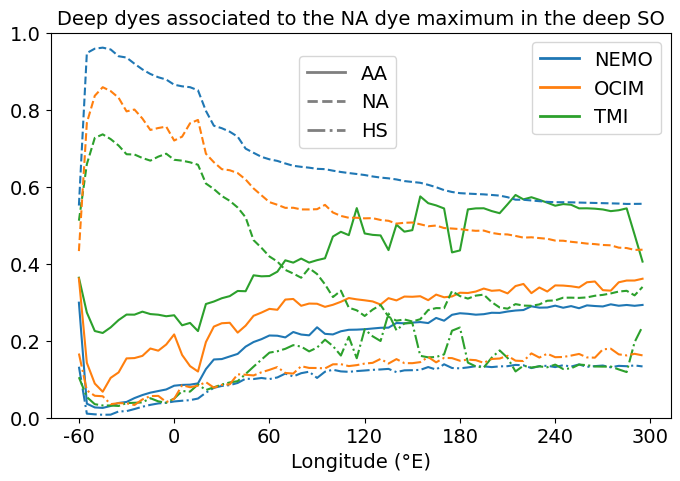

In [31]:
fig = plt.figure(figsize = (8, 5))
ax = plt.gca(); font = 14
ls = ['-', '--', '-.']; colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i in range(len(dyes_deep)):
    ax.plot(lon_reshaped, dye_nemo_max_reshaped[i], label = 'NEMO ' + dyes_deep[i], ls = ls[i], color = '#1f77b4')
    ax.plot(lon_reshaped, dye_tmi_max_reshaped[i], label = 'TMI ' + dyes_deep[i], ls = ls[i], color = '#2ca02c')
    ax.plot(lon_reshaped, dye_ocim_max_reshaped[i], label = 'OCIM ' + dyes_deep[i], ls = ls[i], color = '#ff7f0e')

ax.set_xticks([-60 + i * 60 for i in range(7)]); ax.set_xticklabels([str(-60 + i* 60) for i in range(7)], fontsize = font)
ax.set_yticks([i * 0.2 for i in range(6)]); ax.set_yticklabels([format(i * 0.2, '.1f') for i in range(6)], fontsize = font)
ax.set_xlabel('Longitude (°E)', fontsize = font)
# ax.set_ylabel('Dye concentration', fontsize = font); 
ax.set_ylim(0, 1)
ax.set_title('Deep dyes associated to the NA dye maximum in the deep SO', fontsize = font)

custom_lines = [Line2D([0], [0], color='#1f77b4', lw=2),
                Line2D([0], [0], color='#ff7f0e', lw=2),
                Line2D([0], [0], color='#2ca02c', lw=2)]
first_legend = ax.legend(custom_lines, ['NEMO', 'OCIM', 'TMI'], fontsize = font)

custom_lines = [Line2D([0], [0], color='#7f7f7f', lw=2, ls = ls[0]),
                Line2D([0], [0], color='#7f7f7f', lw=2, ls = ls[1]),
                Line2D([0], [0], color='#7f7f7f', lw=2, ls = ls[2])]
ax.legend(custom_lines, [dyes_deep[0], dyes_deep[1], dyes_deep[2]], fontsize = font, loc = (0.4, 0.7))
ax.add_artist(first_legend)

plt.savefig(fig_path + 'NA_dye_max_ACC.png', bbox_inches = 'tight', transparent = True)

### Plots of the associated d18o and Salinity

<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:12: SyntaxWarning: invalid escape sequence '\d'
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\4240163473.py:12: SyntaxWarning: invalid escape sequence '\d'
  ax.set_ylabel('$\delta^{18}O_{sw} (‰)$', fontsize = font); ax.set_ylim(-0.3, 0.3)


Text(0, 0.5, 'Absolute Salinity (PSU)')

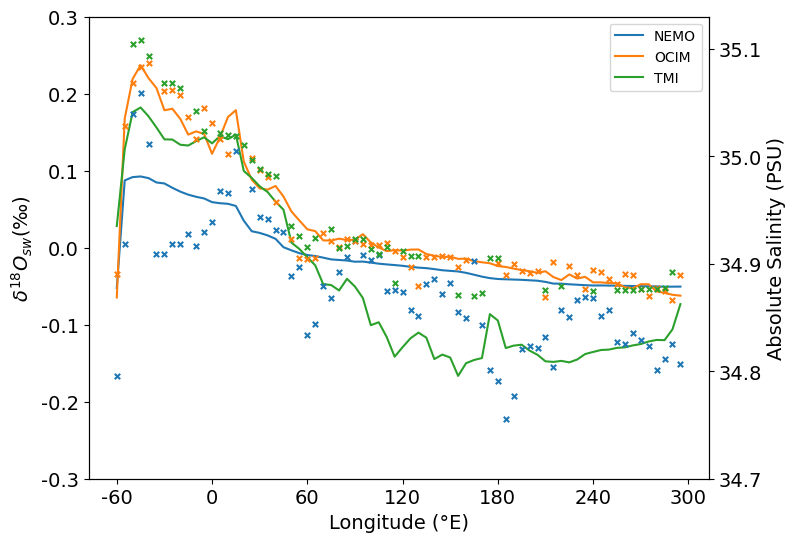

In [32]:
fig = plt.figure(figsize = (8, 6)); ax = plt.gca(); font = 14
ls = ['-', '--', '-.']; colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

ax.plot(lon_reshaped, d18o_na_max_reshaped[0], label = 'NEMO', color = '#1f77b4')
ax.plot(lon_reshaped, d18o_na_max_reshaped[1], label = 'OCIM', color = '#ff7f0e')
ax.plot(lon_reshaped, d18o_na_max_reshaped[2], label = 'TMI', color = '#2ca02c')

ax.set_xticks([-60 + i * 60 for i in range(7)]); ax.set_xticklabels([str(-60 + i* 60) for i in range(7)], fontsize = font)
ax.set_yticks([-0.3 + i * 0.1 for i in range(7)]); ax.set_yticklabels([format(-0.3 + i * 0.1, '.1f') for i in range(7)], fontsize = font)
ax.set_xlabel('Longitude (°E)', fontsize = font)
# ax.set_ylabel('Dye concentration', fontsize = font); 
ax.set_ylabel('$\delta^{18}O_{sw} (‰)$', fontsize = font); ax.set_ylim(-0.3, 0.3)
ax.legend()

ax2 = ax.twinx()

ax2.scatter(lon_reshaped, salinity_associated_reshaped[0], label = 'NEMO', color = '#1f77b4', marker = 'x', s = 15)
ax2.scatter(lon_reshaped, salinity_associated_reshaped[1], label = 'OCIM', color = '#ff7f0e', marker = 'x', s = 15)
ax2.scatter(lon_reshaped, salinity_associated_reshaped[2], label = 'TMI', color = '#2ca02c', marker = 'x', s = 15)

ax2.set_yticks([34.7 + 0.1*i for i in range(5)]); ax2.set_yticklabels([format(34.7 + 0.1*i, '.1f') for i in range(5)], fontsize = font)
ax2.set_ylim(34.7, 35.13); ax2.set_ylabel('Absolute Salinity (PSU)', fontsize = font)

# plt.savefig(root_directory + fig_path + 'd18o_salinity_NA_dye_max_ACC.png', bbox_inches = 'tight', transparent = True)

<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:12: SyntaxWarning: invalid escape sequence '\d'
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\998629995.py:12: SyntaxWarning: invalid escape sequence '\d'
  ax.set_ylabel('$\delta^{18}O_{sw} (‰)$', fontsize = font); ax.set_ylim(-0.3, 0.3)


Text(0, 0.5, 'Absolute Salinity (PSU)')

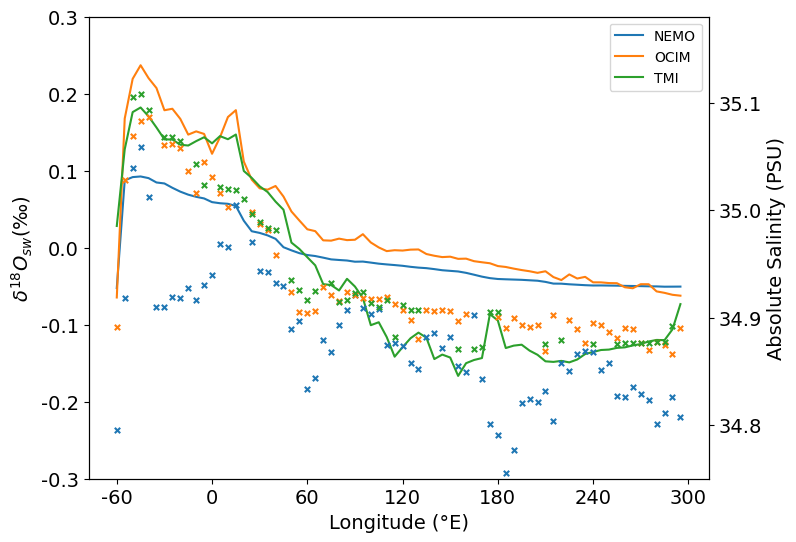

In [33]:
fig = plt.figure(figsize = (8, 6)); ax = plt.gca(); font = 14
ls = ['-', '--', '-.']; colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

ax.plot(lon_reshaped, d18o_na_max_reshaped[0], label = 'NEMO', color = '#1f77b4')
ax.plot(lon_reshaped, d18o_na_max_reshaped[1], label = 'OCIM', color = '#ff7f0e')
ax.plot(lon_reshaped, d18o_na_max_reshaped[2], label = 'TMI', color = '#2ca02c')

ax.set_xticks([-60 + i * 60 for i in range(7)]); ax.set_xticklabels([str(-60 + i* 60) for i in range(7)], fontsize = font)
ax.set_yticks([-0.3 + i * 0.1 for i in range(7)]); ax.set_yticklabels([format(-0.3 + i * 0.1, '.1f') for i in range(7)], fontsize = font)
ax.set_xlabel('Longitude (°E)', fontsize = font)
# ax.set_ylabel('Dye concentration', fontsize = font); 
ax.set_ylabel('$\delta^{18}O_{sw} (‰)$', fontsize = font); ax.set_ylim(-0.3, 0.3)
ax.legend()

ax2 = ax.twinx()

ax2.scatter(lon_reshaped, salinity_associated_reshaped[0], label = 'NEMO', color = '#1f77b4', marker = 'x', s = 15)
ax2.scatter(lon_reshaped, salinity_associated_reshaped[1], label = 'OCIM', color = '#ff7f0e', marker = 'x', s = 15)
ax2.scatter(lon_reshaped, salinity_associated_reshaped[2], label = 'TMI', color = '#2ca02c', marker = 'x', s = 15)

ax2.set_yticks([34.7 + 0.1*i for i in range(5)]); ax2.set_yticklabels([format(34.7 + 0.1*i, '.1f') for i in range(5)], fontsize = font)
ax2.set_ylim(34.75, 35.18); ax2.set_ylabel('Absolute Salinity (PSU)', fontsize = font)

<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:12: SyntaxWarning: invalid escape sequence '\d'
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\857973176.py:12: SyntaxWarning: invalid escape sequence '\d'
  ax.set_ylabel('$\delta^{18}O_{sw} (‰)$', fontsize = font); ax.set_ylim(-0.3, 0.3)


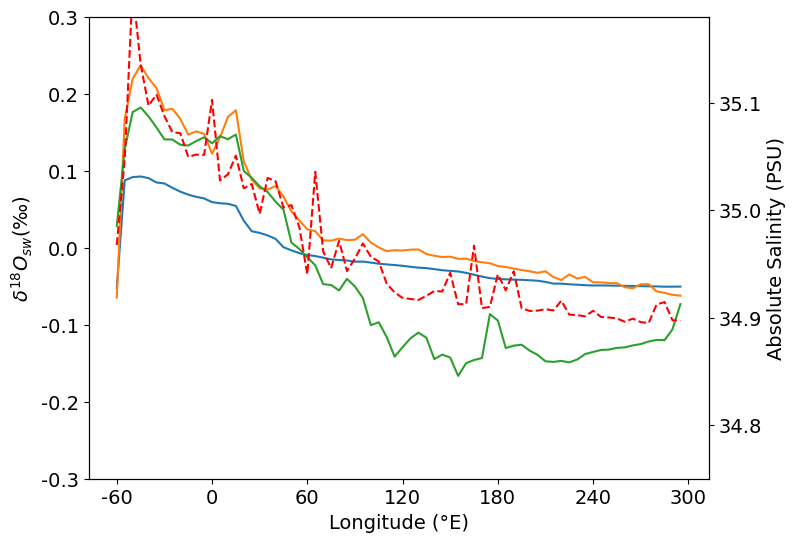

In [34]:
fig = plt.figure(figsize = (8, 6)); ax = plt.gca(); font = 14
ls = ['-', '--', '-.']; colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

ax.plot(lon_reshaped, d18o_na_max_reshaped[0], label = 'NEMO', color = '#1f77b4')
ax.plot(lon_reshaped, d18o_na_max_reshaped[1], label = 'OCIM', color = '#ff7f0e')
ax.plot(lon_reshaped, d18o_na_max_reshaped[2], label = 'TMI', color = '#2ca02c')

ax.set_xticks([-60 + i * 60 for i in range(7)]); ax.set_xticklabels([str(-60 + i* 60) for i in range(7)], fontsize = font)
ax.set_yticks([-0.3 + i * 0.1 for i in range(7)]); ax.set_yticklabels([format(-0.3 + i * 0.1, '.1f') for i in range(7)], fontsize = font)
ax.set_xlabel('Longitude (°E)', fontsize = font)
# ax.set_ylabel('Dye concentration', fontsize = font); 
ax.set_ylabel('$\delta^{18}O_{sw} (‰)$', fontsize = font); ax.set_ylim(-0.3, 0.3)


ax2 = ax.twinx()

ax2.plot(lon_reshaped, max_salinity_reshaped, label = 'NEMO', color = 'red', ls = '--')

ax2.set_yticks([34.7 + 0.1*i for i in range(5)]); ax2.set_yticklabels([format(34.7 + 0.1*i, '.1f') for i in range(5)], fontsize = font)
ax2.set_ylim(34.75, 35.18); ax2.set_ylabel('Absolute Salinity (PSU)', fontsize = font)

plt.savefig(fig_path + 'salinity_max_d18o_NA_max', bbox_inches = 'tight', transparent = True)

### Comparison to the GISS data

Here we try to look at the data which is influenced by the NA waters in the SO.

We select them as the waters that have a neutral density of $27.9 < \gamma < 28.05$ and absolute salinity above 34.8 PSU. 

#### Load the GISS data

In [39]:
d18o = pd.read_table(data_path + 'giss_d18o.txt')
d18o_SO = d18o[d18o['Latitude'] <= -40]
interpolator_gamma = RegularGridInterpolator((l_depth0, l_lat_nemo, l_lon_nemo), dsClim['gamma'].values, bounds_error = False)
interpolator_salinity = RegularGridInterpolator((l_depth0, l_lat_nemo, l_lon_nemo), dsClim['absolute_salinity'].values, bounds_error = False)

In [40]:
d18o_SO['Longitude'] = [lon if lon >= 0 else 360 + lon for lon in d18o_SO['Longitude']]
d18o_SO.where((d18o_SO['Depth'] != -999.0) & (d18o_SO['d18O'] != '**'), np.nan, inplace = True)
d18o_SO['d18O'] = d18o_SO['d18O'].astype(float)
d18o_SO['Gamma'] = interpolator_gamma((d18o_SO['Depth'], d18o_SO['Latitude'], d18o_SO['Longitude']))
d18o_SO['absolute_salinity'] = interpolator_salinity((d18o_SO['Depth'], d18o_SO['Latitude'], d18o_SO['Longitude']))

C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\2535301303.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d18o_SO['Longitude'] = [lon if lon >= 0 else 360 + lon for lon in d18o_SO['Longitude']]
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\2535301303.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d18o_SO.where((d18o_SO['Depth'] != -999.0) & (d18o_SO['d18O'] != '**'), np.nan, inplace = True)
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\2535301303.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [41]:
aux = d18o_SO.where((d18o_SO['Gamma'] <= 28.6) & (d18o_SO['Gamma'] >= 27)).dropna()
dfs = uf.create_dfs(aux)

In [42]:
dfs3 = []; i = 0
for df in dfs:
    df['Longitude2'] = [lon if lon <= 293 else lon - 360 for lon in df['Longitude'].values]
    dfs3.append(df.where((d18o_SO['Gamma'] <= 28.05) & (d18o_SO['Gamma'] >= 27.9) & (d18o_SO['absolute_salinity'] >= 34.8)).dropna(ignore_index = True))
    
    i += 1

#### Plot the d18o from the different models with the data

<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\1141064220.py:13: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xlabel('Longitude (°E)', fontsize = font); ax.set_ylabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font)
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\1141064220.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(dfs3[i]['Longitude2'], dfs3[i]['d18O'], marker = 'x', c = couleurs[i])


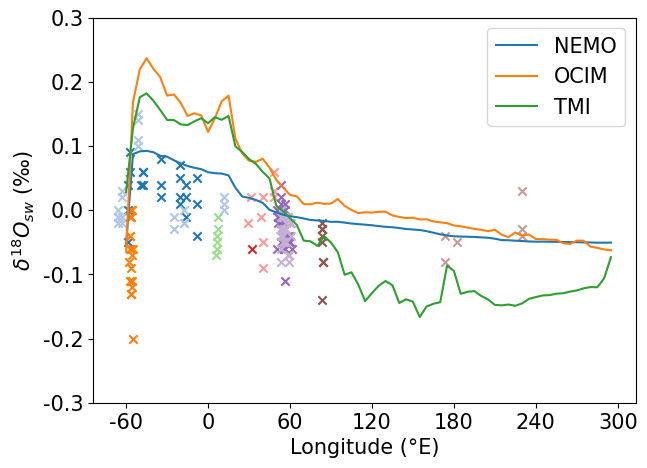

In [43]:
fig = plt.figure(figsize = (7, 5)); ax = plt.gca()

couleurs = plt.cm.tab20(range(12))
for i in range(12):
    plt.scatter(dfs3[i]['Longitude2'], dfs3[i]['d18O'], marker = 'x', c = couleurs[i])

ax.plot(lon_reshaped, d18o_na_max_reshaped[0], label = 'NEMO', color = '#1f77b4')
ax.plot(lon_reshaped, d18o_na_max_reshaped[1], label = 'OCIM', color = '#ff7f0e')
ax.plot(lon_reshaped, d18o_na_max_reshaped[2], label = 'TMI', color = '#2ca02c')

ax.set_xticks([-60 + i * 60 for i in range(7)]); ax.set_xticklabels([str(-60 + i* 60) for i in range(7)], fontsize = font)
ax.set_yticks([-0.3 + i * 0.1 for i in range(7)]); ax.set_yticklabels([format(-0.3 + i * 0.1, '.1f') for i in range(7)], fontsize = font)
ax.set_xlabel('Longitude (°E)', fontsize = font); ax.set_ylabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font)

ax.legend(fontsize = font)

<>:37: SyntaxWarning: invalid escape sequence '\d'
<>:37: SyntaxWarning: invalid escape sequence '\d'
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\1016191480.py:37: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xlabel('Longitude (°E)', fontsize = font); ax.set_ylabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font)
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\1016191480.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(dfs3[i]['Longitude2'], dfs3[i]['d18O'], marker = 'x', c = couleurs[i])


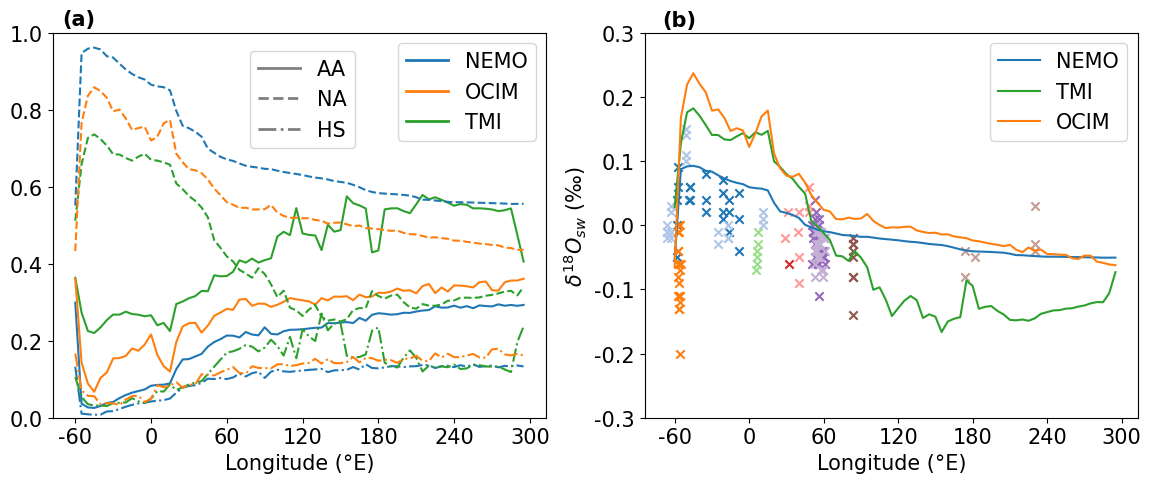

In [44]:
fig = plt.figure(figsize = (14, 5)); gs = fig.add_gridspec(1, 2, wspace = 0.2); font = 15

ax = fig.add_subplot(gs[0, 0])
ls = ['-', '--', '-.']; colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for i in range(len(dyes_deep)):
    ax.plot(lon_reshaped, dye_nemo_max_reshaped[i], label = 'NEMO ' + dyes_deep[i], ls = ls[i], color = '#1f77b4')
    ax.plot(lon_reshaped, dye_tmi_max_reshaped[i], label = 'TMI ' + dyes_deep[i], ls = ls[i], color = '#2ca02c')
    ax.plot(lon_reshaped, dye_ocim_max_reshaped[i], label = 'OCIM ' + dyes_deep[i], ls = ls[i], color = '#ff7f0e')

ax.set_xticks([-60 + i * 60 for i in range(7)]); ax.set_xticklabels([str(-60 + i* 60) for i in range(7)], fontsize = font)
ax.set_yticks([i * 0.2 for i in range(6)]); ax.set_yticklabels([format(i * 0.2, '.1f') for i in range(6)], fontsize = font)
ax.set_xlabel('Longitude (°E)', fontsize = font)
# ax.set_ylabel('Dye concentration', fontsize = font); 
ax.set_ylim(0, 1); ax.text(-70, 1.02, '(a)', fontsize = font, fontweight = 'bold')
custom_lines = [Line2D([0], [0], color='#1f77b4', lw=2),
                Line2D([0], [0], color='#ff7f0e', lw=2),
                Line2D([0], [0], color='#2ca02c', lw=2)]
first_legend = ax.legend(custom_lines, ['NEMO', 'OCIM', 'TMI'], fontsize = font)

custom_lines = [Line2D([0], [0], color='#7f7f7f', lw=2, ls = ls[0]),
                Line2D([0], [0], color='#7f7f7f', lw=2, ls = ls[1]),
                Line2D([0], [0], color='#7f7f7f', lw=2, ls = ls[2])]
ax.legend(custom_lines, [dyes_deep[0], dyes_deep[1], dyes_deep[2]], fontsize = font, loc = (0.4, 0.7))
ax.add_artist(first_legend)


ax = fig.add_subplot(gs[0, 1])
for i in range(12):
    plt.scatter(dfs3[i]['Longitude2'], dfs3[i]['d18O'], marker = 'x', c = couleurs[i])

ax.plot(lon_reshaped, d18o_na_max_reshaped[0], label = 'NEMO', color = '#1f77b4')
ax.plot(lon_reshaped, d18o_na_max_reshaped[2], label = 'TMI', color = '#2ca02c')
ax.plot(lon_reshaped, d18o_na_max_reshaped[1], label = 'OCIM', color = '#ff7f0e')

ax.set_xticks([-60 + i * 60 for i in range(7)]); ax.set_xticklabels([str(-60 + i* 60) for i in range(7)], fontsize = font)
ax.set_yticks([-0.3 + i * 0.1 for i in range(7)]); ax.set_yticklabels([format(-0.3 + i * 0.1, '.1f') for i in range(7)], fontsize = font)
ax.set_xlabel('Longitude (°E)', fontsize = font); ax.set_ylabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font)
ax.text(-70, 0.31, '(b)', fontsize = font, fontweight = 'bold')

ax.legend(fontsize = font)
plt.savefig(fig_path + 'd18o_SO_data_models_NA_density.png', bbox_inches = 'tight')

# Comparison to other datasets

In [45]:
dsClim = xr.open_dataset(data_path + 'WOCE_climatology_Lg&S_d18o.nc')
l_lat_clim, l_lon_clim = dsClim['lat'].values, dsClim['lon'].values; l_depth0 = uf.create_l_depth()
interpolator_gamma_clim = RegularGridInterpolator((l_depth0, l_lat_clim, l_lon_clim), dsClim['gamma'].values, bounds_error = False)
interpolator_salinity = RegularGridInterpolator((l_depth0, l_lat_clim, l_lon_clim), dsClim['absolute_salinity'].values, bounds_error = False)
interpolator_d18o_GISS = RegularGridInterpolator((l_depth0, l_lat_clim, l_lon_clim), dsClim['seawater_d18O'].values, bounds_error = False)

In [46]:
nemo_d18o = xr.open_dataset(data_path + 'nemo_reconstructed_d18o.nc')
l_depth = nemo_d18o['depth'].values
interpolator_d18o_rcst_nemo = RegularGridInterpolator((l_depth, l_lat_clim, l_lon_clim), nemo_d18o['d18o_recons'].values, bounds_error = False)

In [47]:
ocim_d18o = xr.open_dataset(data_path + 'ocim_reconstructed_d18o.nc')
l_lon_ocim, l_lat_ocim, l_depth_ocim = ocim_d18o['xt'].values, ocim_d18o['yt'].values, ocim_d18o['zt'].values
interpolator_d18o_rcst_ocim = RegularGridInterpolator((l_depth_ocim, l_lat_ocim, l_lon_ocim), ocim_d18o['d18o_recons'].values, bounds_error = False)

In [48]:
TMI_d18o = xr.open_dataset(data_path + 'tmi_reconstructed_d18o.nc')
l_lon_tmi, l_lat_tmi, l_depth_tmi = TMI_d18o['xt'].values, TMI_d18o['yt'].values, TMI_d18o['zt'].values
interpolator_d18o_rcst_tmi = RegularGridInterpolator((l_depth_tmi, l_lat_tmi, l_lon_tmi), TMI_d18o['d18o_recons'].values, bounds_error = False)

## Look at the Aoki dataset

In [49]:
aoki_d18o = pd.read_csv(data_path + 'Datasheet_KY2018_ADS_20230718.csv', sep = ";", skiprows = [1])

In [50]:
aoki_d18o = aoki_d18o.where((aoki_d18o['dO18'] != -999.) & (aoki_d18o['CTDPRS_DBAR'] >= 200)).dropna(ignore_index = True)

In [51]:
interpolator_gamma_GISS = RegularGridInterpolator((l_depth0, l_lat_clim, l_lon_clim), dsClim['gamma'].values, bounds_error = False)

In [52]:
aoki_d18o['d18O_rcst_nemo'] = interpolator_d18o_rcst_nemo((aoki_d18o['CTDPRS_DBAR'], aoki_d18o['LATITUDE_DEG'], aoki_d18o['LONGITUDE_DEG']))
aoki_d18o['d18O_rcst_ocim'] = interpolator_d18o_rcst_ocim((aoki_d18o['CTDPRS_DBAR'], aoki_d18o['LATITUDE_DEG'], aoki_d18o['LONGITUDE_DEG']))
aoki_d18o['d18O_rcst_tmi'] = interpolator_d18o_rcst_tmi((aoki_d18o['CTDPRS_DBAR'], aoki_d18o['LATITUDE_DEG'], aoki_d18o['LONGITUDE_DEG']))
aoki_d18o['Gamma'] = interpolator_gamma_GISS((aoki_d18o['CTDPRS_DBAR'], aoki_d18o['LATITUDE_DEG'], aoki_d18o['LONGITUDE_DEG']))

In [53]:
l_ds = []
for i in range(8):
    if i==0: l_ds.append(aoki_d18o.where((aoki_d18o['LONGITUDE_DEG'] <= 90) & (aoki_d18o['LONGITUDE_DEG'] >= 79)).dropna(ignore_index = True))
    elif i==7: l_ds.append(aoki_d18o.where((aoki_d18o['LONGITUDE_DEG'] <= 151) & (aoki_d18o['LONGITUDE_DEG'] >= 140)).dropna(ignore_index = True))
    else: l_ds.append(aoki_d18o.where((aoki_d18o['LONGITUDE_DEG'] <= 90 + i *10) & (aoki_d18o['LONGITUDE_DEG'] >= 80 + i * 10)).dropna(ignore_index = True))

<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:29: SyntaxWarning: invalid escape sequence '\g'
<>:31: SyntaxWarning: invalid escape sequence '\D'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:29: SyntaxWarning: invalid escape sequence '\g'
<>:31: SyntaxWarning: invalid escape sequence '\D'
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\218932187.py:28: SyntaxWarning: invalid escape sequence '\d'
  if xlabels: ax.set_xlabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font)
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\218932187.py:29: SyntaxWarning: invalid escape sequence '\g'
  if ylabels: ax.set_ylabel('$\gamma_n$', fontsize = font, rotation = 0, labelpad = 10)
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\218932187.py:31: SyntaxWarning: invalid escape sequence '\D'
  ax.text(-0.4, 28.5, '$Mean(\Delta)$ = ' + format(np.nanmean(np.sqrt((l_ds[i]['dO18'] - l_ds[i]['d18O_rcst_' + model_label])**2)), '.3f'), fontsize = font, color = 'goldenrod')


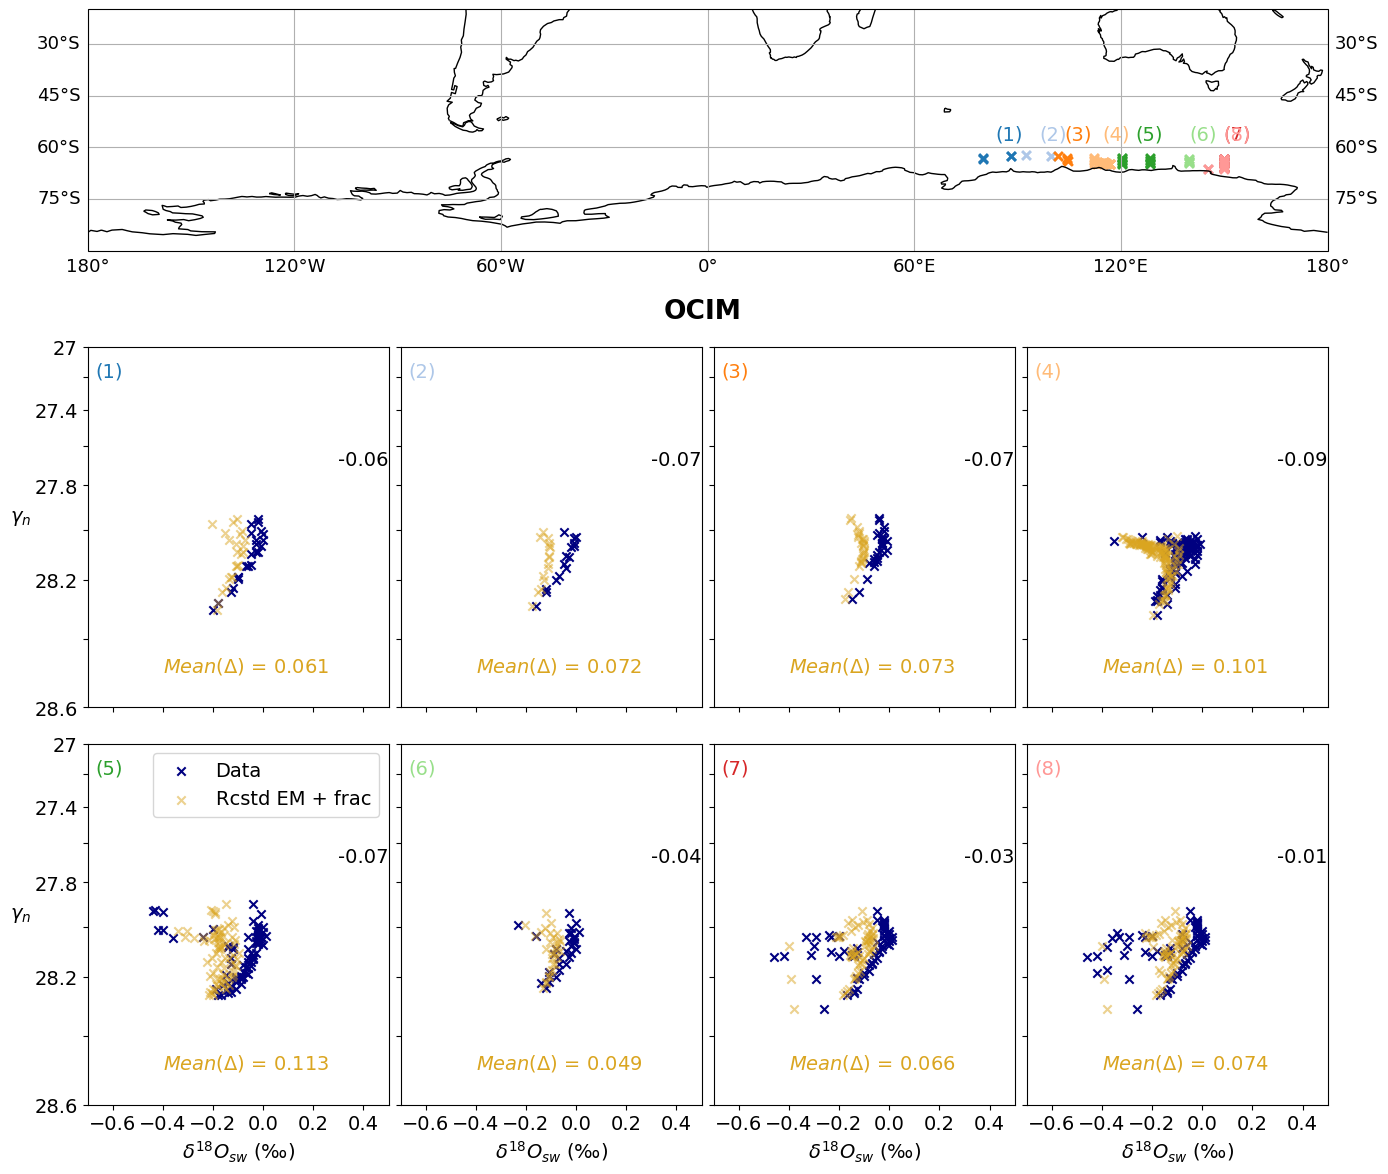

In [54]:
fig = plt.figure(figsize = (16, 15)); gs = fig.add_gridspec(3, 4, wspace = 0.04, hspace = 0.1); font = 14

# labels = nemo, ocim, tmi
model_label = 'ocim'

ax = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree())
ax.coastlines(resolution='110m')
gl = ax.gridlines(draw_labels = {'bottom': 'x', 'right': 'y', 'left': 'y'}, ylocs = [-90 + 15 * i for i in range(5)])
gl.xlabel_style = {'size': font - 1}; gl.ylabel_style = {'size': font - 1}
ax.set_ylim(-90, -20); ax.set_xlim(-180, 180)
couleurs = plt.cm.tab20(range(12))
for i in range(8):
    ax.scatter(l_ds[i]['LONGITUDE_DEG'], l_ds[i]['LATITUDE_DEG'], color = couleurs[i], marker = 'x')
    ax.text(np.nanmean(l_ds[i]['LONGITUDE_DEG']), -58, '(' + str(i+1) + ')', fontsize = font, color = couleurs[i])

norm_S = uf.get_BoundNorm(34, 35, nbins = 20)
for i in range(8):
    i_row, i_col = i//4 + 1, i%4; xlabels, ylabels = uf.get_xylabels(2, 4, i)
    
    if (i_row == 1) & (i_col==2): ax.text(0.35, 26.8, model_label.upper(), fontsize = font + 5, fontweight = 'bold')
        
    ax = fig.add_subplot(gs[i_row, i_col])
    sc = ax.scatter(l_ds[i]['dO18'], l_ds[i]['Gamma'], marker = 'x', c = 'navy', alpha = 1, label = 'Data') #, norm = norm_S)
    ax.scatter(l_ds[i]['d18O_rcst_' + model_label], l_ds[i]['Gamma'], marker = 'x', c = 'goldenrod', alpha = .5, label = 'Rcstd EM + frac')

    if i ==4: ax.legend(fontsize = font)
    
    if xlabels: ax.set_xlabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font)
    if ylabels: ax.set_ylabel('$\gamma_n$', fontsize = font, rotation = 0, labelpad = 10)

    ax.text(-0.4, 28.5, '$Mean(\Delta)$ = ' + format(np.nanmean(np.sqrt((l_ds[i]['dO18'] - l_ds[i]['d18O_rcst_' + model_label])**2)), '.3f'), fontsize = font, color = 'goldenrod')
    ax.text(-0.67, 27.2, '(' + str(i + 1) + ')', fontsize = font, color = couleurs[i])
    ax.text(0.3, 27.7, format(np.nanmean(l_ds[i]['d18O_rcst_' + model_label] - l_ds[i]['dO18']), '.2f'), fontsize = font)
    
    ax.set_yscale('custom_scale')
    uf.plot_details_axis(ax, sc, cb = False, xlim = (-0.7, 0.5), ylim = (28.6, 27), nbins = 20, xticks = [-0.6 + 0.2*i for i in range(6)], yticks = [27 + 0.2*i for i in range(9)], font = font, xlabels = xlabels, ylabels = ylabels)
    ax.invert_yaxis()
    if ylabels: ax.set_yticklabels(['27', '', '27.4', '', '27.8', '', '28.2', '', '28.6'], fontsize = font)

plt.savefig(fig_path + 'd18o_profiles_aoki_SO_map_' + model_label + '_rcs_mean.png', bbox_inches = 'tight')

In [55]:
ocim_d18o['d18o_recons'].values[39, 13, 64]

np.float64(-0.20480277721204113)

## Comparison to the CISE-LOCEAN database

In [56]:
import cartopy.crs as ccrs

In [57]:
d18o_Indian = pd.read_csv(data_path + 'SI-Wisotopes-V3.csv', delimiter=';', names=['Cruise name', 'station id', 'bottle number', 'day', 'month', 'year', 'hour', 'minute', 'latitude', 'longitude', 'pressure (db)', 'temperature (°C)', 'it', 'salinity (pss-78)', 'is', 'dissolved oxygen (micromol/kg)', 'io2', 'd18O', 'iO', 'dD', 'iD', 'd-excess', 'id', 'method type'])

In [58]:
d18o_Indian.where((d18o_Indian['iO'] <= 2), inplace = True)
d18o_Indian_deep = d18o_Indian.where(d18o_Indian['pressure (db)']>=500).dropna(how='all')

(20.0, 120.0)

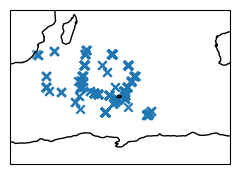

In [59]:
fig=plt.figure(figsize=(4, 2))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.coastlines(resolution='110m')

sc = ax.scatter(d18o_Indian_deep['longitude'], d18o_Indian_deep['latitude'], marker = 'x', alpha = 0.8)
ax.set_ylim(-80, -10); ax.set_xlim(20, 120)

In [60]:
aux = d18o_Indian_deep.where(d18o_Indian_deep['longitude']>= 40).dropna()

In [61]:
l_lon_ocim[20:46]

array([41., 43., 45., 47., 49., 51., 53., 55., 57., 59., 61., 63., 65.,
       67., 69., 71., 73., 75., 77., 79., 81., 83., 85., 87., 89., 91.])

In [62]:
d18o_ocim_avg = np.nanmean(ocim_d18o['d18o_recons'][:, :, 20:46], axis = 2)
d18o_tmi_avg = np.nanmean(TMI_d18o['d18o_recons'][:, :, 20:46], axis = 2)

C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\1694425854.py:1: RuntimeWarning: Mean of empty slice
  d18o_ocim_avg = np.nanmean(ocim_d18o['d18o_recons'][:, :, 20:46], axis = 2)
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\1694425854.py:2: RuntimeWarning: Mean of empty slice
  d18o_tmi_avg = np.nanmean(TMI_d18o['d18o_recons'][:, :, 20:46], axis = 2)


In [63]:
from scipy.interpolate import RegularGridInterpolator

In [64]:
interp_d18o_Indian_ocim = RegularGridInterpolator((l_depth_ocim, l_lat_ocim, l_lon_ocim[20:46]), ocim_d18o['d18o_recons'].values[:, :, 20:46], bounds_error = False, fill_value = None)
aux['predicted_d18o_ocim'] = interp_d18o_Indian_ocim((aux['pressure (db)'], aux['latitude'], aux['longitude']))

interp_d18o_Indian_tmi = RegularGridInterpolator((l_depth_tmi, l_lat_tmi, l_lon_tmi[20:46]), TMI_d18o['d18o_recons'].values[:, :, 20:46], bounds_error = False, fill_value = None)
aux['predicted_d18o_tmi'] = interp_d18o_Indian_tmi((aux['pressure (db)'], aux['latitude'], aux['longitude']))

In [65]:
l_diff_ocim, l_diff_tmi = [], []
for i in range(30):
    l_diff_ocim.append(np.sqrt(np.nanmean((aux['predicted_d18o_ocim'] - (aux['d18O'] - 0.01 * i))**2)))
    l_diff_tmi.append(np.sqrt(np.nanmean((aux['predicted_d18o_tmi'] - (aux['d18O'] - 0.01 * i))**2)))

In [66]:
print('Offset OCIM: (', np.argmin(l_diff_ocim) * 0.01, '‰)')
print('Offset TMI: (', np.argmin(l_diff_ocim) * 0.01, '‰)')

Offset OCIM: ( 0.15 ‰)
Offset TMI: ( 0.15 ‰)


In [67]:
l_lon_clim[80:181]

array([40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5, 44. , 44.5, 45. ,
       45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. , 49.5, 50. , 50.5,
       51. , 51.5, 52. , 52.5, 53. , 53.5, 54. , 54.5, 55. , 55.5, 56. ,
       56.5, 57. , 57.5, 58. , 58.5, 59. , 59.5, 60. , 60.5, 61. , 61.5,
       62. , 62.5, 63. , 63.5, 64. , 64.5, 65. , 65.5, 66. , 66.5, 67. ,
       67.5, 68. , 68.5, 69. , 69.5, 70. , 70.5, 71. , 71.5, 72. , 72.5,
       73. , 73.5, 74. , 74.5, 75. , 75.5, 76. , 76.5, 77. , 77.5, 78. ,
       78.5, 79. , 79.5, 80. , 80.5, 81. , 81.5, 82. , 82.5, 83. , 83.5,
       84. , 84.5, 85. , 85.5, 86. , 86.5, 87. , 87.5, 88. , 88.5, 89. ,
       89.5, 90. ])

In [68]:
interp_d18o_Indian_giss = RegularGridInterpolator((l_depth0, l_lat_clim, l_lon_clim[80:181]), dsClim['seawater_d18O'].values[:, :, 80:181], bounds_error = False, fill_value = None)
aux['predicted_d18o_GISS'] = interp_d18o_Indian_giss((aux['pressure (db)'], aux['latitude'], aux['longitude']))

<>:31: SyntaxWarning: invalid escape sequence '\d'
<>:31: SyntaxWarning: invalid escape sequence '\d'
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\3465726315.py:31: SyntaxWarning: invalid escape sequence '\d'
  uf.add_cbar(fig, cf, fontsize = font - 1, width = 0.022, ticks = [-0.4 + 0.2 * i for i in range(5)], label = '$\delta^{18}O_{sw} (‰)$')
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\3465726315.py:24: RuntimeWarning: Mean of empty slice
  cf = ax.contourf(l_lat_clim, l_depth0, np.nanmean(dsClim['seawater_d18O'].values[:, :, 80:181], axis = 2), levels = [-0.4 + 0.05*i for i in range(18)], cmap = 'coolwarm', extend = 'both')


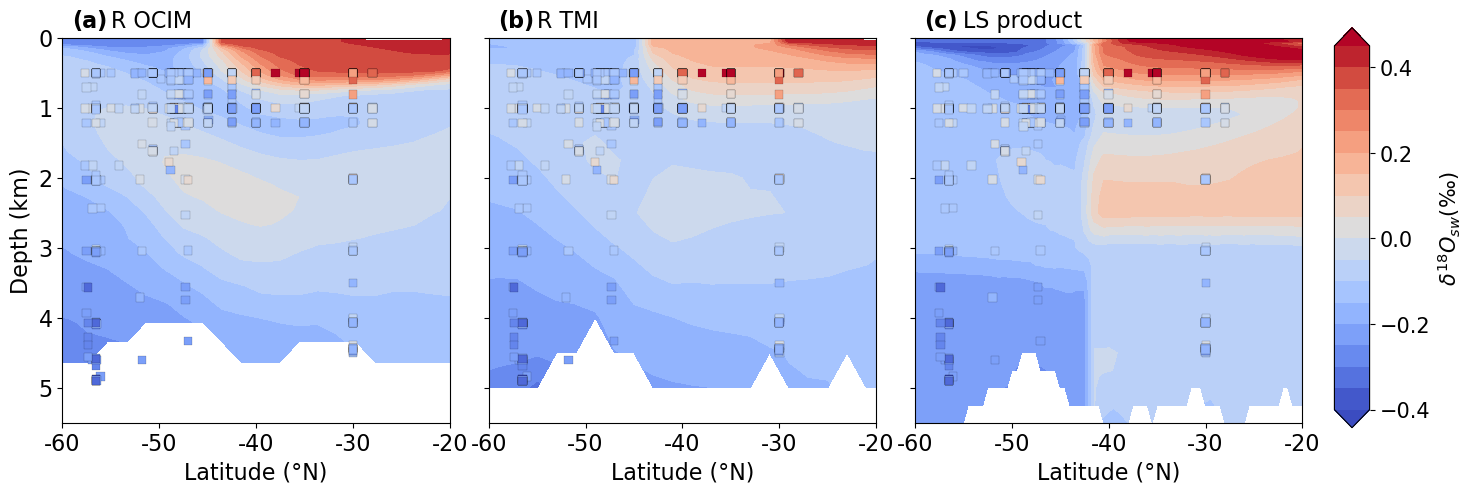

In [70]:
fig = plt.figure(figsize = (16, 5)); gs = fig.add_gridspec(1, 3, wspace = 0.1); font = 16
norm = uf.get_BoundNorm(-0.4, 0.4, nbins = 18)

ax = fig.add_subplot(gs[0, 0])

cf = ax.contourf(l_lat_ocim, l_depth_ocim, d18o_ocim_avg, levels = [-0.4 + 0.05*i for i in range(18)], cmap = 'coolwarm')
sc = ax.scatter(aux['latitude'], aux['pressure (db)'], c = aux['d18O']-.15, marker = 's', cmap = 'coolwarm',
                norm = norm, edgecolor = 'black', linewidth = .1)
ax.set_ylim(5500, 0); ax.set_xlim(-60, -20)
ax.set_xlabel('Latitude (°N)', fontsize = font); ax.set_xticks([-60 + 10 * i for i in range(5)]); ax.set_xticklabels([-60 + 10 * i for i in range(5)], fontsize = font)
ax.set_ylabel('Depth (km)', fontsize = font); ax.set_yticks([1000 * i for i in range(6)]); ax.set_yticklabels([i for i in range(6)], fontsize = font)
ax.text(-59, -150, '(a)', fontsize = font, fontweight = 'bold'); ax.text(-55, -150, 'R OCIM', fontsize = font)

ax = fig.add_subplot(gs[0, 1])
cf = ax.contourf(l_lat_tmi, l_depth_tmi, d18o_tmi_avg, levels = [-0.4 + 0.05*i for i in range(18)], cmap = 'coolwarm')
sc = ax.scatter(aux['latitude'], aux['pressure (db)'], c = aux['d18O']-.15, marker = 's', cmap = 'coolwarm',
                norm = norm, edgecolor = 'black', linewidth = .1)
ax.set_ylim(5500, 0); ax.set_xlim(-60, -20)
ax.set_xlabel('Latitude (°N)', fontsize = font); ax.set_xticks([-60 + 10 * i for i in range(5)]); ax.set_xticklabels([-60 + 10 * i for i in range(5)], fontsize = font)
ax.set_yticks([1000 * i for i in range(6)]); ax.set_yticklabels([], fontsize = font)
ax.text(-59, -150, '(b)', fontsize = font, fontweight = 'bold'); ax.text(-55, -150, 'R TMI', fontsize = font)

ax = fig.add_subplot(gs[0, 2])
cf = ax.contourf(l_lat_clim, l_depth0, np.nanmean(dsClim['seawater_d18O'].values[:, :, 80:181], axis = 2), levels = [-0.4 + 0.05*i for i in range(18)], cmap = 'coolwarm', extend = 'both')
sc = ax.scatter(aux['latitude'], aux['pressure (db)'], c = aux['d18O']-.15, marker = 's', cmap = 'coolwarm',
                norm = norm, edgecolor = 'black', linewidth = .1)
ax.set_ylim(5500, 0); ax.set_xlim(-60, -20)
ax.set_xlabel('Latitude (°N)', fontsize = font); ax.set_xticks([-60 + 10 * i for i in range(5)]); ax.set_xticklabels([-60 + 10 * i for i in range(5)], fontsize = font)
ax.set_yticks([1000 * i for i in range(6)]); ax.set_yticklabels([], fontsize = font)
ax.text(-59, -150, '(c)', fontsize = font, fontweight = 'bold'); ax.text(-55, -150, 'LS product', fontsize = font)
uf.add_cbar(fig, cf, fontsize = font - 1, width = 0.022, ticks = [-0.4 + 0.2 * i for i in range(5)], label = '$\delta^{18}O_{sw} (‰)$')

plt.savefig(fig_path + 'South_Indian_rcst_d18o_OCIM_TMI_GISS_databaseLOCEAN.png', bbox_inches = 'tight')

In [71]:
dsClim['practical_salinity']

<xarray.DataArray 'practical_salinity' (Depth: 45, Latitude: 341, Longitude: 720)> Size: 88MB
[11048400 values with dtype=float64]
Dimensions without coordinates: Depth, Latitude, Longitude
Attributes:
    units:    PSS-78

C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\2954273222.py:3: RuntimeWarning: Mean of empty slice
  cf = ax.contourf(l_lat_clim, l_depth0, np.nanmean(dsClim['preformed_salinity'].values[:, :, 80:181], axis = 2), cmap = 'coolwarm', levels = [34.4 + 0.05*i for i in range(20)], extend = 'both')


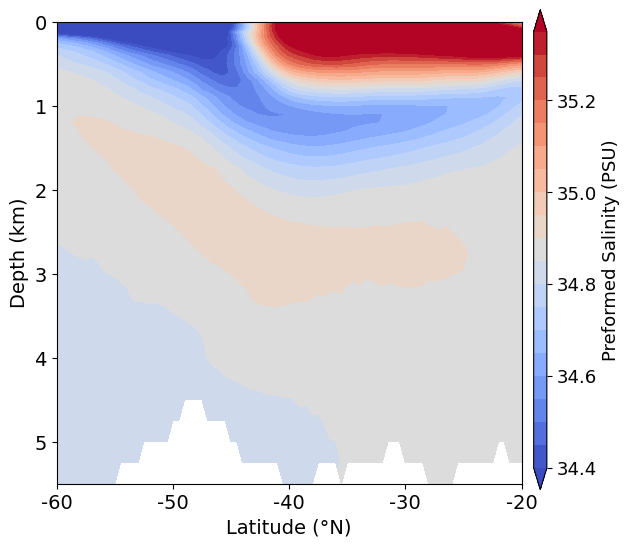

In [72]:
fig = plt.figure(figsize = (6, 6)); ax = plt.gca(); font = 14

cf = ax.contourf(l_lat_clim, l_depth0, np.nanmean(dsClim['preformed_salinity'].values[:, :, 80:181], axis = 2), cmap = 'coolwarm', levels = [34.4 + 0.05*i for i in range(20)], extend = 'both')
ax.set_ylim(5500, 0); ax.set_xlim(-60, -20)
ax.set_xlabel('Latitude (°N)', fontsize = font); ax.set_xticks([-60 + 10 * i for i in range(5)]); ax.set_xticklabels([-60 + 10 * i for i in range(5)], fontsize = font)
ax.set_ylabel('Depth (km)', fontsize = font); ax.set_yticks([1000 * i for i in range(6)]); ax.set_yticklabels([i for i in range(6)], fontsize = font)
uf.add_cbar(fig, cf, fontsize = font - 1, width = 0.022, ticks = [34.4 + 0.2 * i for i in range(5)], label = 'Preformed Salinity (PSU)')

## Helen Bostock data

In [74]:
HB_d18o = pd.read_excel(data_path + 'd18o_helen_bostock.xlsx')
pd_d18o = HB_d18o.dropna(subset = ['Longitude [°]']).reset_index()

In [75]:
l_stations = pd_d18o['CTD Station #'].unique()

In [76]:
pd_d18o['gamma'] = interpolator_gamma_clim((pd_d18o['CTD Pressure [decibars]'], pd_d18o['Latitude [°]'], pd_d18o['Longitude [°]']))
pd_d18o['d18O_ocim'] = interpolator_d18o_rcst_ocim((pd_d18o['CTD Pressure [decibars]'], pd_d18o['Latitude [°]'], pd_d18o['Longitude [°]']))
pd_d18o['d18O_tmi'] = interpolator_d18o_rcst_tmi((pd_d18o['CTD Pressure [decibars]'], pd_d18o['Latitude [°]'], pd_d18o['Longitude [°]']))

In [77]:
field = 'Longitude [°]'
pd_d18o[field].min(), pd_d18o[field].max()

(139.83133, 150.0216667)

In [78]:
aux = pd_d18o.where((pd_d18o['CTD Pressure [decibars]'] >= 150)).dropna(how = 'all')
grouped = aux.groupby('CTD Station #')
l_max_depth = []; dfs_SO = {}; l_names = []

for name, group in grouped:
    l_names.append(name)
    l_max_depth.append(np.nanmax(group['CTD Pressure [decibars]']))
    dfs_SO[name] = group

In [79]:
depth_min_station = 3000
filtered_data = grouped.filter(lambda x: x['CTD Pressure [decibars]'].max() >= depth_min_station)

<>:22: SyntaxWarning: invalid escape sequence '\d'
<>:22: SyntaxWarning: invalid escape sequence '\g'
<>:35: SyntaxWarning: invalid escape sequence '\d'
<>:22: SyntaxWarning: invalid escape sequence '\d'
<>:22: SyntaxWarning: invalid escape sequence '\g'
<>:35: SyntaxWarning: invalid escape sequence '\d'
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\4148352139.py:22: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xlabel('$\delta^{18}O_{sw}$', fontsize = font); ax.set_ylabel('$\gamma_n$', fontsize = font, rotation = 0, labelpad = 10)
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\4148352139.py:22: SyntaxWarning: invalid escape sequence '\g'
  ax.set_xlabel('$\delta^{18}O_{sw}$', fontsize = font); ax.set_ylabel('$\gamma_n$', fontsize = font, rotation = 0, labelpad = 10)
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\4148352139.py:35: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xlabel('$\delta^{18}O_{sw}$', fontsize = font); # ax.set_ylabel('$\gamma_n$', 

Text(-0.68, 27.15, '(c)')

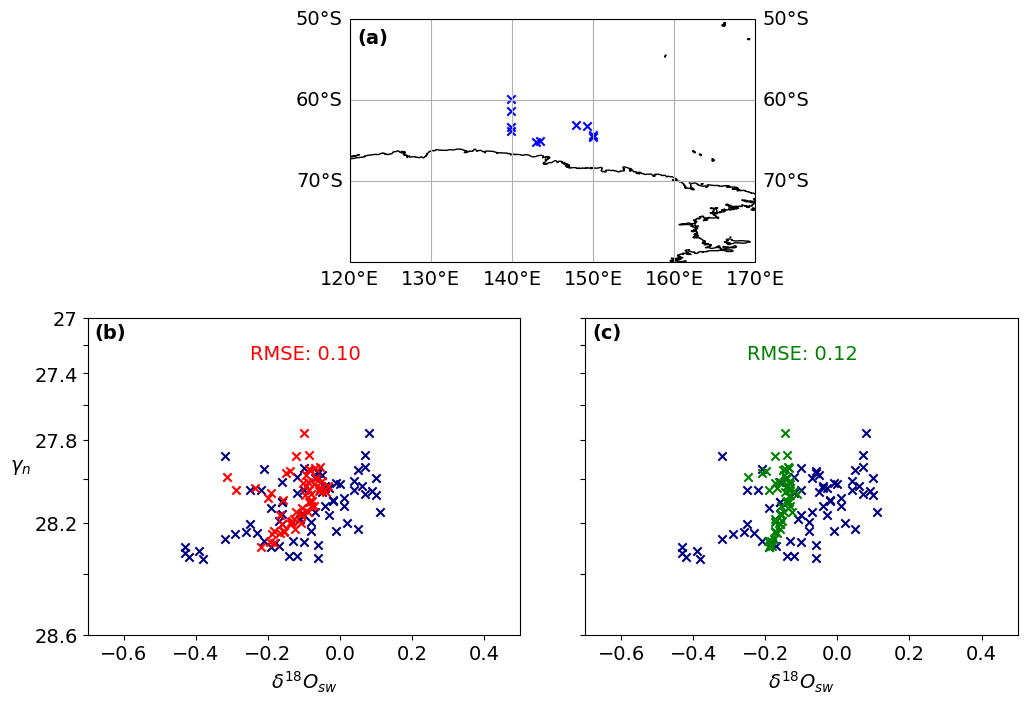

In [80]:
fig = plt.figure(figsize = (12, 8)); gs = fig.add_gridspec(2, 2, wspace = .15, height_ratios = [1, 1.3])
font = 14

ax = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))

ax.coastlines(resolution='10m')
gl = ax.gridlines(draw_labels = {'bottom': 'x', 'right': 'y', 'left': 'y'}, xlocs = [120 + i *10 for i in range(7)], ylocs = [-80 + 10 * i for i in range(5)])
gl.xlabel_style = {'size': font}; gl.ylabel_style = {'size': font}
sc = ax.scatter(filtered_data['Longitude [°]'].unique(), filtered_data['Latitude [°]'].unique(), marker = 'x', color = 'blue')
ax.set_ylim(-80, -49.99); ax.set_xlim(119.999, 170.001)
ax.text(121, -53, '(a)', fontsize = font, fontweight = 'bold')


ax = fig.add_subplot(gs[1, 0])

sc = ax.scatter(filtered_data['δ18O VSMOW'], filtered_data['gamma'], marker = 'x', c = 'navy')
sc = ax.scatter(filtered_data['d18O_ocim'], filtered_data['gamma'], marker = 'x', c = 'red')

ax.text(-0.25, 27.3, 'RMSE: ' + format(np.nanmean(np.sqrt((filtered_data['d18O_ocim'] - filtered_data['δ18O VSMOW'])**2)), '.2f'), fontsize = font, color = 'red')
ax.set_yscale('custom_scale'); ax.invert_yaxis()
uf.plot_details_axis(ax, sc, cb = False, xlim = (-0.7, 0.5), ylim = (27, 28.6), nbins = 20, xticks = [-0.6 + 0.2*i for i in range(6)], yticks = [27 + 0.2*i for i in range(9)], font = font)
ax.set_xlabel('$\delta^{18}O_{sw}$', fontsize = font); ax.set_ylabel('$\gamma_n$', fontsize = font, rotation = 0, labelpad = 10)
ax.set_yticklabels(['27', '', '27.4', '', '27.8', '', '28.2', '', '28.6'], fontsize = font)
ax.text(-0.68, 27.15, '(b)', fontsize = font, fontweight = 'bold')


ax = fig.add_subplot(gs[1, 1])

sc = ax.scatter(filtered_data['δ18O VSMOW'], filtered_data['gamma'], marker = 'x', c = 'navy')
sc = ax.scatter(filtered_data['d18O_tmi'], filtered_data['gamma'], marker = 'x', c = 'green')

ax.text(-0.25, 27.3, 'RMSE: ' + format(np.nanmean(np.sqrt((filtered_data['d18O_tmi'] - filtered_data['δ18O VSMOW'])**2)), '.2f'), fontsize = font, color = 'green')
ax.set_yscale('custom_scale'); ax.invert_yaxis()
uf.plot_details_axis(ax, sc, cb = False, xlim = (-0.7, 0.5), ylim = (27, 28.6), nbins = 20, xticks = [-0.6 + 0.2*i for i in range(6)], yticks = [27 + 0.2*i for i in range(9)], font = font)
ax.set_xlabel('$\delta^{18}O_{sw}$', fontsize = font); # ax.set_ylabel('$\gamma_n$', fontsize = font, rotation = 0, labelpad = 10)
ax.set_yticklabels([], fontsize = font)
ax.text(-0.68, 27.15, '(c)', fontsize = font, fontweight = 'bold')


# plt.savefig(fig_path + 'd18o_profiles_helen_SO_recons_' + str(int(depth_min_station)) +'m.png', bbox_inches = 'tight')

In [81]:
influence_NA = (pd_d18o['gamma'] >= 27.9) & (pd_d18o['gamma'] <= 28.05) & (pd_d18o['CTD Salinity [PSS-78]'] >= 34.7)
aux = pd_d18o.where((pd_d18o['CTD Pressure [decibars]'] >= 150) & influence_NA).dropna(how = 'all')
grouped = aux.groupby('CTD Station #')
l_max_depth = []; dfs_SO = {}; l_names = []

for name, group in grouped:
    l_names.append(name)
    l_max_depth.append(np.nanmax(group['CTD Pressure [decibars]']))
    dfs_SO[name] = group

<>:24: SyntaxWarning: invalid escape sequence '\d'
<>:24: SyntaxWarning: invalid escape sequence '\g'
<>:39: SyntaxWarning: invalid escape sequence '\d'
<>:24: SyntaxWarning: invalid escape sequence '\d'
<>:24: SyntaxWarning: invalid escape sequence '\g'
<>:39: SyntaxWarning: invalid escape sequence '\d'
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\166276327.py:24: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xlabel('$\delta^{18}O_{sw}$', fontsize = font); ax.set_ylabel('$\gamma_n$', fontsize = font, rotation = 0, labelpad = 10)
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\166276327.py:24: SyntaxWarning: invalid escape sequence '\g'
  ax.set_xlabel('$\delta^{18}O_{sw}$', fontsize = font); ax.set_ylabel('$\gamma_n$', fontsize = font, rotation = 0, labelpad = 10)
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\166276327.py:39: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xlabel('$\delta^{18}O_{sw}$', fontsize = font); ax.set_ylabel('', fontsize = font

Text(-0.45, 28.54, 'TMI')

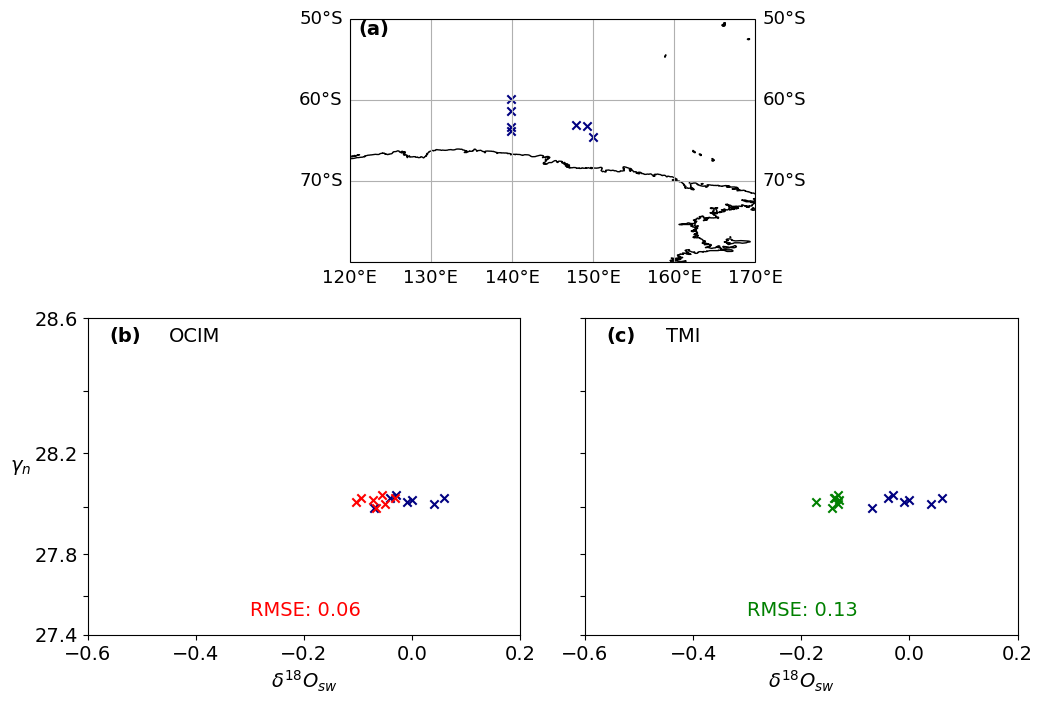

In [82]:
fig = plt.figure(figsize = (12, 8)); gs = fig.add_gridspec(2, 2, wspace = .15, height_ratios = [1, 1.3])
font = 14

ax = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
gl = ax.gridlines(draw_labels = {'bottom': 'x', 'right': 'y', 'left': 'y'}, ylocs = [-80 + 10 * i for i in range(5)])
gl.xlabel_style = {'size': font - 1}; gl.ylabel_style = {'size': font - 1}
ax.set_ylim(-80.01, -49.99); ax.set_xlim(119.99, 170.01)
ax.scatter(aux['Longitude [°]'], aux['Latitude [°]'], color = 'navy', marker = 'x')
ax.text(121, -52, '(a)', fontsize = font, fontweight = 'bold')


ax = fig.add_subplot(gs[1, 0])
# for i in range(len(l_names)):
#     if l_max_depth[i] >= 3000:
#         sc = ax.scatter(dfs_SO[l_names[i]]['δ18O VSMOW'], dfs_SO[l_names[i]]['gamma'], marker = 'x', c = 'navy')
#         sc = ax.scatter(dfs_SO[l_names[i]]['d18o_ocim'], dfs_SO[l_names[i]]['gamma'], marker = 'x', c = 'red')
sc = ax.scatter(aux['δ18O VSMOW'], aux['gamma'], marker = 'x', c = 'navy')
sc = ax.scatter(aux['d18O_ocim'], aux['gamma'], marker = 'x', c = 'red')

ax.text(-0.3, 27.5, 'RMSE: ' + format(np.nanmean(np.sqrt((aux['d18O_ocim'] - aux['δ18O VSMOW'])**2)), '.2f'), fontsize = font, color = 'red')
ax.set_yscale('custom_scale'); ax.invert_yaxis()
uf.plot_details_axis(ax, sc, cb = False, xlim = (-0.6, 0.2), ylim = (28.6, 27.4), nbins = 20, xticks = [-0.6 + 0.2*i for i in range(6)], yticks = [27 + 0.2*i for i in range(9)], font = font)
ax.set_xlabel('$\delta^{18}O_{sw}$', fontsize = font); ax.set_ylabel('$\gamma_n$', fontsize = font, rotation = 0, labelpad = 10)
ax.set_yticklabels([27, '', 27.4, '', 27.8, '', 28.2, '', 28.6], fontsize = font); ax.text(-0.56, 28.54, '(b)', fontsize = font, fontweight = 'bold'); ax.text(-0.45, 28.54, 'OCIM', fontsize = font,)


ax = fig.add_subplot(gs[1, 1])
# for i in range(len(l_names)):
#     if l_max_depth[i] >= 3000:
#         sc = ax.scatter(dfs_SO[l_names[i]]['δ18O VSMOW'], dfs_SO[l_names[i]]['gamma'], marker = 'x', c = 'navy')
#         sc = ax.scatter(dfs_SO[l_names[i]]['d18o_tmi'], dfs_SO[l_names[i]]['gamma'], marker = 'x', c = 'green')
sc = ax.scatter(aux['δ18O VSMOW'], aux['gamma'], marker = 'x', c = 'navy')
sc = ax.scatter(aux['d18O_tmi'], aux['gamma'], marker = 'x', c = 'green')

ax.text(-0.3, 27.5, 'RMSE: ' + format(np.nanmean(np.sqrt((aux['d18O_tmi'] - aux['δ18O VSMOW'])**2)), '.2f'), fontsize = font, color = 'green')
ax.set_yscale('custom_scale'); ax.invert_yaxis()
uf.plot_details_axis(ax, sc, cb = False, xlim = (-0.6, 0.2), ylim = (28.6, 27.4), nbins = 20, xticks = [-0.6 + 0.2*i for i in range(6)], yticks = [27 + 0.2*i for i in range(9)], font = font)
ax.set_xlabel('$\delta^{18}O_{sw}$', fontsize = font); ax.set_ylabel('', fontsize = font, rotation = 0, labelpad = 10)
ax.set_yticklabels([], fontsize = font); ax.text(-0.56, 28.54, '(c)', fontsize = font, fontweight = 'bold');  ax.text(-0.45, 28.54, 'TMI', fontsize = font,)

# plt.savefig(fig_path + 'HB_data_recons_OCIM_TMI_NAinf.png', bbox_inches = 'tight')

In [85]:
d18o = pd.read_table(data_path + 'giss_d18o.txt')
d18o_SO = d18o[d18o['Latitude'] <= -40]
interpolator_gamma = RegularGridInterpolator((l_depth0, l_lat_clim, l_lon_clim), dsClim['gamma'].values, bounds_error = False)
interpolator_salinity = RegularGridInterpolator((l_depth0, l_lat_clim, l_lon_clim), dsClim['absolute_salinity'].values, bounds_error = False)

In [86]:
d18o_SO['Longitude'] = [lon if lon >= 0 else 360 + lon for lon in d18o_SO['Longitude']]
d18o_SO.where((d18o_SO['Depth'] != -999.0) & (d18o_SO['d18O'] != '**'), np.nan, inplace = True)
d18o_SO['d18O'] = d18o_SO['d18O'].astype(float)
d18o_SO['Gamma'] = interpolator_gamma((d18o_SO['Depth'], d18o_SO['Latitude'], d18o_SO['Longitude']))
d18o_SO['absolute_salinity'] = interpolator_salinity((d18o_SO['Depth'], d18o_SO['Latitude'], d18o_SO['Longitude']))

C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\2535301303.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d18o_SO['Longitude'] = [lon if lon >= 0 else 360 + lon for lon in d18o_SO['Longitude']]
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\2535301303.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d18o_SO.where((d18o_SO['Depth'] != -999.0) & (d18o_SO['d18O'] != '**'), np.nan, inplace = True)
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\2535301303.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [87]:
aux_SO = d18o_SO.where((d18o_SO['Gamma'] <= 28.6) & (d18o_SO['Gamma'] >= 27)).dropna()
dfs = uf.create_dfs(aux_SO)

In [88]:
dfs = uf.create_dfs(aux_SO)
dfs3 = []; i = 0
for df in dfs:
    df['Longitude2'] = [lon if lon <= 293 else lon - 360 for lon in df['Longitude'].values]
    dfs3.append(df.where((d18o_SO['Gamma'] <= 28.05) & (d18o_SO['Gamma'] >= 27.9) & (d18o_SO['absolute_salinity'] >= 34.8)).dropna(ignore_index = True))
    
    i += 1

<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\71391716.py:15: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xlabel('Longitude (°E)', fontsize = font); ax.set_ylabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font)
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\71391716.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(dfs3[i]['Longitude2'], dfs3[i]['d18O'], marker = 'x', c = couleurs[i])


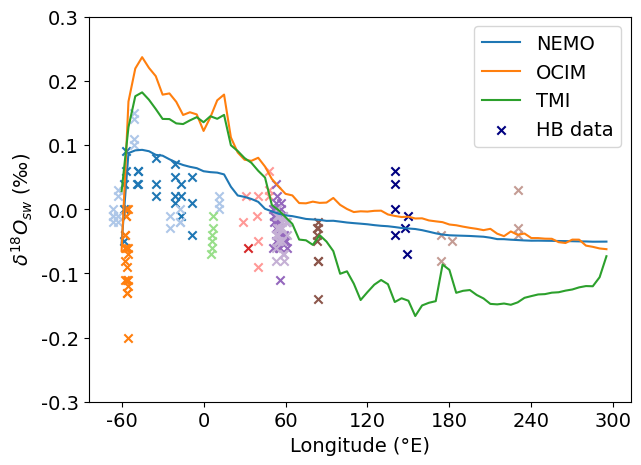

In [89]:
fig = plt.figure(figsize = (7, 5)); ax = plt.gca()

couleurs = plt.cm.tab20(range(12))
for i in range(12):
    plt.scatter(dfs3[i]['Longitude2'], dfs3[i]['d18O'], marker = 'x', c = couleurs[i])

ax.plot(lon_reshaped, d18o_na_max_reshaped[0], label = 'NEMO', color = '#1f77b4')
ax.plot(lon_reshaped, d18o_na_max_reshaped[1], label = 'OCIM', color = '#ff7f0e')
ax.plot(lon_reshaped, d18o_na_max_reshaped[2], label = 'TMI', color = '#2ca02c')

ax.scatter(aux['Longitude [°]'], aux['δ18O VSMOW'], color = 'navy', label = 'HB data', marker = 'x')

ax.set_xticks([-60 + i * 60 for i in range(7)]); ax.set_xticklabels([str(-60 + i* 60) for i in range(7)], fontsize = font)
ax.set_yticks([-0.3 + i * 0.1 for i in range(7)]); ax.set_yticklabels([format(-0.3 + i * 0.1, '.1f') for i in range(7)], fontsize = font)
ax.set_xlabel('Longitude (°E)', fontsize = font); ax.set_ylabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font)

ax.legend(fontsize = font)

# plt.savefig(fig_path + 'd18o_SO_data_models_NA_density_HB.png', bbox_inches = 'tight')

## Zoom on the Indian GISS data

In [91]:
d18o_Giss_Indian = pd.read_table(data_path + 'giss_d18o_Indian.txt')
d18o = pd.read_table(data_path + 'giss_d18o.txt')
d18o_SO = d18o[d18o['Latitude'] <= -40]

In [92]:
d18o_Giss_Indian['Longitude'] = [lon if lon >= 0 else 360 + lon for lon in d18o_Giss_Indian['Longitude']]
d18o_Giss_Indian.where(d18o_Giss_Indian['Depth'] != -999.0, np.nan, inplace = True)

In [93]:
d18o_Giss_Indian['gamma'] = interpolator_gamma_clim((d18o_Giss_Indian['Depth'], d18o_Giss_Indian['Latitude'], d18o_Giss_Indian['Longitude']))
d18o_Giss_Indian['d18O_ocim'] = interpolator_d18o_rcst_ocim((d18o_Giss_Indian['Depth'], d18o_Giss_Indian['Latitude'], d18o_Giss_Indian['Longitude']))

d18o_SO['gamma'] = interpolator_gamma_clim((d18o_SO['Depth'], d18o_SO['Latitude'], d18o_SO['Longitude']))
d18o_SO['d18O_ocim'] = interpolator_d18o_rcst_ocim((d18o_SO['Depth'], d18o_SO['Latitude'], d18o_SO['Longitude']))

C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\2817376424.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d18o_SO['gamma'] = interpolator_gamma_clim((d18o_SO['Depth'], d18o_SO['Latitude'], d18o_SO['Longitude']))
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\2817376424.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d18o_SO['d18O_ocim'] = interpolator_d18o_rcst_ocim((d18o_SO['Depth'], d18o_SO['Latitude'], d18o_SO['Longitude']))


In [94]:
aux = d18o_Giss_Indian.where((d18o_Giss_Indian['gamma'] <= 28.6) & (d18o_Giss_Indian['gamma'] >= 27) & (d18o_Giss_Indian['d18O'] != '**')).dropna()
aux['d18O'] = aux['d18O'].astype(float)

In [95]:
southern_dataset = True

<>:26: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\d'
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\2050374190.py:26: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xlabel('$\delta^{18}O_{sw}$', fontsize = font, rotation = 0, labelpad = 10); ax.set_xticks([-0.6 + 0.2*i for i in range(6)]); ax.set_xticklabels([format(-0.6 + 0.2*i, '.1f') for i in range(6)], fontsize = font)
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_31684\2050374190.py:38: SyntaxWarning: invalid escape sequence '\d'
  ax.set_xlabel('$\delta^{18}O_{sw}$', fontsize = font, rotation = 0, labelpad = 10); ax.set_xticks([-0.6 + 0.2*i for i in range(6)]); ax.set_xticklabels([format(-0.6 + 0.2*i, '.1f') for i in range(6)], fontsize = font)


Text(-0.6, 500, '(2)')

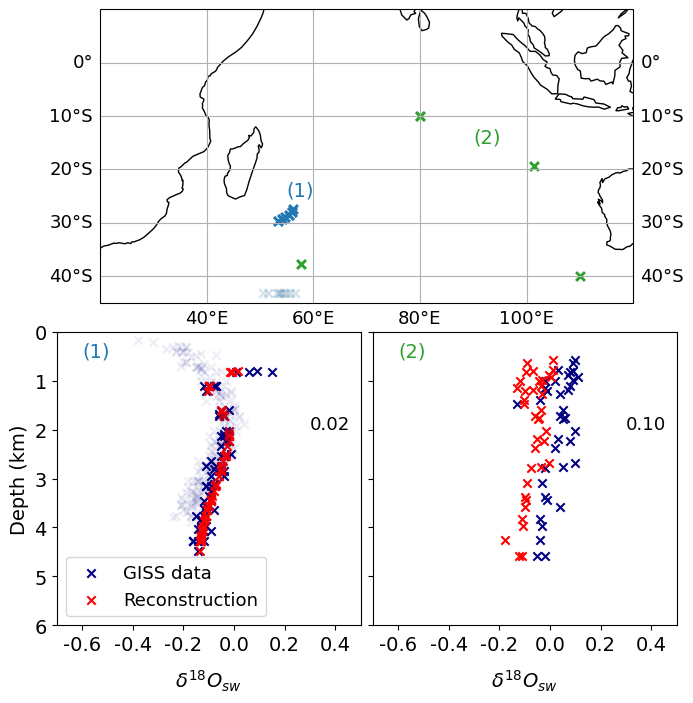

In [96]:
fig = plt.figure(figsize = (8, 8)); gs = fig.add_gridspec(2, 2, wspace = 0.04, hspace = 0.1); font = 14

ax = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree(central_longitude=0))
ax.coastlines(resolution='110m')
dfs2 = d18o_SO.where((d18o_SO['Reference'] == 'ADOX2 (Frew et al 1995)') & (d18o_SO['gamma'] >= 27)).dropna()
dfs2 = dfs2.where(dfs2['d18O'] != '**').dropna()
dfs2['d18O'] = dfs2['d18O'].astype(float)
couleurs = plt.cm.tab20(range(8))

dfs, dfs1 = aux.where(aux['Reference'] == 'ADOX2 (Frew et al 1995)').dropna(), aux.where(aux['Reference'] == 'GEOSECS Ostlund et al (1987)').dropna()
sc = ax.scatter(dfs['Longitude'], dfs['Latitude'], marker = 'x', alpha = 0.8, color = couleurs[0])
sc = ax.scatter(dfs2['Longitude'], dfs2['Latitude'], marker = 'x', alpha = 0.02, color = couleurs[0])
sc = ax.scatter(dfs1['Longitude'], dfs1['Latitude'], marker = 'x', alpha = 0.8, color = couleurs[4])
gl = ax.gridlines(draw_labels = {'bottom': 'x', 'right': 'y', 'left': 'y'}, ylocs = [-40 + 10 * i for i in range(5)])
gl.xlabel_style = {'size': font - 1}; gl.ylabel_style = {'size': font - 1}
ax.set_ylim(-45, 10); ax.set_xlim(20, 120)
ax.text(55, -25, '(1)', color = couleurs[0], fontsize = font); ax.text(90, -15, '(2)', color = couleurs[4], fontsize = font)

ax = fig.add_subplot(gs[1, 0])

sc = ax.scatter(dfs['d18O'].values, dfs['Depth'].values, marker = 'x', c = 'navy', label = 'GISS data')
sc = ax.scatter(dfs['d18O_ocim'].values, dfs['Depth'].values, marker = 'x', c = 'red', label = 'Reconstruction')
ax.text(0.3, 2000, format(np.nanmean(np.sqrt((dfs['d18O_ocim'] - dfs['d18O'])**2)), '.2f'), fontsize = font - 1)
# ax.axhline(y = l_neut_dens[i], ls = '--', color = couleurs[i], alpha = 0.5); ax.text(0.15, l_neut_dens[i] + 0.05, '$\gamma$ =' + str(l_neut_dens[i]), fontsize = font - 1, color = couleurs[i])
ax.set_ylabel('Depth (km)', fontsize = font); ax.set_yticks([1000 * i for i in range(7)]); ax.set_yticklabels([i for i in range(7)], fontsize = font)
ax.set_xlabel('$\delta^{18}O_{sw}$', fontsize = font, rotation = 0, labelpad = 10); ax.set_xticks([-0.6 + 0.2*i for i in range(6)]); ax.set_xticklabels([format(-0.6 + 0.2*i, '.1f') for i in range(6)], fontsize = font)
ax.set_ylim(6000, 0); ax.set_xlim(-0.7, 0.5)
ax.text(-0.6, 500, '(1)', fontsize = font, color = couleurs[0])
ax.legend(fontsize = font - 1)
if southern_dataset: ax.scatter(dfs2['d18O'].values, dfs2['Depth'].values, marker = 'x', c = 'navy', alpha = 0.07)

ax = fig.add_subplot(gs[1, 1])

sc = ax.scatter(dfs1['d18O'].values, dfs1['Depth'].values, marker = 'x', c = 'navy')
sc = ax.scatter(dfs1['d18O_ocim'].values, dfs1['Depth'].values, marker = 'x', c = 'red')
ax.text(0.3, 2000, format(np.nanmean(np.sqrt((dfs1['d18O_ocim'] - dfs1['d18O'])**2)), '.2f'), fontsize = font - 1)
ax.set_yticks([1000 * i for i in range(7)]); ax.set_yticklabels([], fontsize = font)
ax.set_xlabel('$\delta^{18}O_{sw}$', fontsize = font, rotation = 0, labelpad = 10); ax.set_xticks([-0.6 + 0.2*i for i in range(6)]); ax.set_xticklabels([format(-0.6 + 0.2*i, '.1f') for i in range(6)], fontsize = font)
ax.set_ylim(6000, 0); ax.set_xlim(-0.7, 0.5)
ax.text(-0.6, 500, '(2)', fontsize = font, color = couleurs[4])

# plt.savefig(fig_path + 'd18o_Indian_GISS_ocim.png', bbox_inches = 'tight')